# 一、环境、库导入

In [1]:
# 简化print
# 克隆仓库（静默模式）
!git clone https://github.com/microsoft/BatteryML.git > /dev/null 2>&1 && echo "✅ 仓库克隆完成" || echo "❌ 克隆失败"

# 查看关键文件结构（只显示主要目录）
!ls -la BatteryML/ | head -10

# 安装依赖（静默模式）
!cd BatteryML && pip install -r requirements.txt -q && echo "✅ 依赖安装完成" || echo "❌ 依赖安装失败"

# 安装BatteryML包（静默模式）
!cd BatteryML && pip install . -q && echo "✅ BatteryML安装完成" || echo "❌ BatteryML安装失败"

# 验证安装
!python -c "import batteryml; print('✅ BatteryML导入成功')" 2>/dev/null || echo "❌ BatteryML导入失败"

✅ 仓库克隆完成
total 736
drwxr-xr-x  7 root root   4096 Aug 24 10:46 .
drwxr-xr-x  3 root root   4096 Aug 24 10:46 ..
-rw-r--r--  1 root root 642332 Aug 24 10:46 baseline.ipynb
drwxr-xr-x 10 root root   4096 Aug 24 10:46 batteryml
drwxr-xr-x  2 root root   4096 Aug 24 10:46 bin
-rw-r--r--  1 root root    444 Aug 24 10:46 CODE_OF_CONDUCT.md
drwxr-xr-x  5 root root   4096 Aug 24 10:46 configs
-rw-r--r--  1 root root   4903 Aug 24 10:46 dataprepare.md
-rw-r--r--  1 root root     79 Aug 24 10:46 .flake8
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 2.4 MB/s eta 0:00:00
✅ 依赖安装完成
  Preparing metadata (setup.py) ... done
✅ BatteryML安装完成
✅ BatteryML导入成功


## 1.1无SOC的图像与代码

In [2]:
import pickle
import pandas as pd
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import inspect
import glob
import pprint


from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import medfilt
from typing import List, Tuple, Optional, Dict, Any


from batteryml.builders import FEATURE_EXTRACTORS
from batteryml.data.battery_data import BatteryData
from batteryml.feature.base import BaseFeatureExtractor
from batteryml.visualization import plot_helper
from batteryml.visualization.plot_helper import inner_plot_capacity_degradation, plot_capacity_degradation
from tqdm import tqdm  # 用于进度条显示（可选）

import copy
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path

# NCA电池

In [3]:
#分类且只加载NCA电池
import glob
import os
import re

def classify_batteries_final(pickle_files):
    """
    根据文件名中的Tongji编号进行最终分类
    """
    nca_batteries = []      # Tongji1 -> NCA (3.5Ah)
    ncm_batteries = []      # Tongji2 -> NCM (3.5Ah)  
    ncm_nca_batteries = []  # Tongji3 -> NCM+NCA (2.5Ah)
    classification_errors = []
    
    print("🔍 根据Tongji编号进行最终分类...")
    
    for i, file_path in enumerate(pickle_files):
        try:
            battery = BatteryData.load(file_path)
            filename = os.path.basename(file_path)
            nominal_capacity = getattr(battery, 'nominal_capacity_in_Ah', None)
            
            classification_info = {
                'file_path': file_path,
                'filename': filename,
                'battery': battery,
                'nominal_capacity': nominal_capacity
            }
            
            # 根据文件名中的Tongji编号分类
            if filename.startswith('Tongji1_'):
                nca_batteries.append(classification_info)
                battery_type = 'NCA'
            elif filename.startswith('Tongji2_'):
                ncm_batteries.append(classification_info)
                battery_type = 'NCM'
            elif filename.startswith('Tongji3_'):
                ncm_nca_batteries.append(classification_info)
                battery_type = 'NCM+NCA'
            else:
                classification_errors.append(classification_info)
                battery_type = 'UNKNOWN'
            
            if (i + 1) % 30 == 0:
                print(f"📊 已分类 {i + 1}/{len(pickle_files)} 个文件")
                print(f"   NCA: {len(nca_batteries)}, NCM: {len(ncm_batteries)}, NCM+NCA: {len(ncm_nca_batteries)}")
        
        except Exception as e:
            classification_errors.append({
                'file_path': file_path,
                'filename': os.path.basename(file_path),
                'error': str(e),
                'battery': None
            })
    
    return nca_batteries, ncm_batteries, ncm_nca_batteries, classification_errors

# 执行最终分类
pickle_files = glob.glob("/kaggle/input/tongji-dataset-complete/tongji_dataset_complete/*.pkl")
nca_batteries, ncm_batteries, ncm_nca_batteries, errors = classify_batteries_final(pickle_files)

# 显示最终分类结果
print("\n" + "="*60)
print("🎯 最终电池分类结果:")
print("="*60)
print(f"NCA电池 (Tongji1): {len(nca_batteries)} 个")
print(f"NCM电池 (Tongji2): {len(ncm_batteries)} 个") 
print(f"NCM+NCA电池 (Tongji3): {len(ncm_nca_batteries)} 个")
print(f"分类错误: {len(errors)} 个")

# 验证容量信息
print("\n📋 容量验证:")
categories = [
    ("NCA (Tongji1)", nca_batteries),
    ("NCM (Tongji2)", ncm_batteries), 
    ("NCM+NCA (Tongji3)", ncm_nca_batteries)
]

for name, batteries in categories:
    if batteries:
        capacities = [b['nominal_capacity'] for b in batteries if b['nominal_capacity']]
        avg_capacity = sum(capacities) / len(capacities) if capacities else 0
        print(f"{name}: {len(batteries)} 个电池, 平均容量: {avg_capacity:.2f}Ah")
        
        # 显示前3个样本
        print(f"  样本文件:")
        for i, battery_info in enumerate(batteries[:3]):
            print(f"    {i+1}. {battery_info['filename']} - {battery_info['nominal_capacity']}Ah")

# 提取NCA电池用于后续分析
if nca_batteries:
    nca_battery_objects = [info['battery'] for info in nca_batteries]
    print(f"\n✅ 成功提取 {len(nca_battery_objects)} 个NCA电池用于分析")
    
    # 将NCA电池赋值给all_batteries以便后续SOH分析代码使用
    all_batteries = nca_battery_objects
    
    print(f"\n🔋 NCA电池数据概览:")
    if nca_battery_objects:
        sample = nca_battery_objects[0]
        print(f"  标称容量: {getattr(sample, 'nominal_capacity_in_Ah', 'N/A')} Ah")
        print(f"  循环数据: {len(getattr(sample, 'cycle_data', []))} 个循环")
        print(f"  可用于SOH分析: ✅")
else:
    print("\n❌ 没有找到NCA电池")
    all_batteries = []

print(f"\n🎉 分类完成！现在可以使用 all_batteries 变量进行NCA电池的SOH分析")

🔍 根据Tongji编号进行最终分类...
📊 已分类 30/130 个文件
   NCA: 15, NCM: 11, NCM+NCA: 4
📊 已分类 60/130 个文件
   NCA: 34, NCM: 22, NCM+NCA: 4
📊 已分类 90/130 个文件
   NCA: 44, NCM: 40, NCM+NCA: 6
📊 已分类 120/130 个文件
   NCA: 60, NCM: 53, NCM+NCA: 7

🎯 最终电池分类结果:
NCA电池 (Tongji1): 66 个
NCM电池 (Tongji2): 55 个
NCM+NCA电池 (Tongji3): 9 个
分类错误: 0 个

📋 容量验证:
NCA (Tongji1): 66 个电池, 平均容量: 3.50Ah
  样本文件:
    1. Tongji1_CY35-05_1--3.pkl - 3.5Ah
    2. Tongji1_CY25-05_1--1.pkl - 3.5Ah
    3. Tongji1_CY25-025_1--4.pkl - 3.5Ah
NCM (Tongji2): 55 个电池, 平均容量: 3.50Ah
  样本文件:
    1. Tongji2_CY45-05_1--26.pkl - 3.5Ah
    2. Tongji2_CY25-05_1--12.pkl - 3.5Ah
    3. Tongji2_CY45-05_1--10.pkl - 3.5Ah
NCM+NCA (Tongji3): 9 个电池, 平均容量: 2.50Ah
  样本文件:
    1. Tongji3_CY25-05_4--2.pkl - 2.5Ah
    2. Tongji3_CY25-05_4--1.pkl - 2.5Ah
    3. Tongji3_CY25-05_2--3.pkl - 2.5Ah

✅ 成功提取 66 个NCA电池用于分析

🔋 NCA电池数据概览:
  标称容量: 3.5 Ah
  循环数据: 30 个循环
  可用于SOH分析: ✅

🎉 分类完成！现在可以使用 all_batteries 变量进行NCA电池的SOH分析


# 二、图像可视化

test 1 outliers


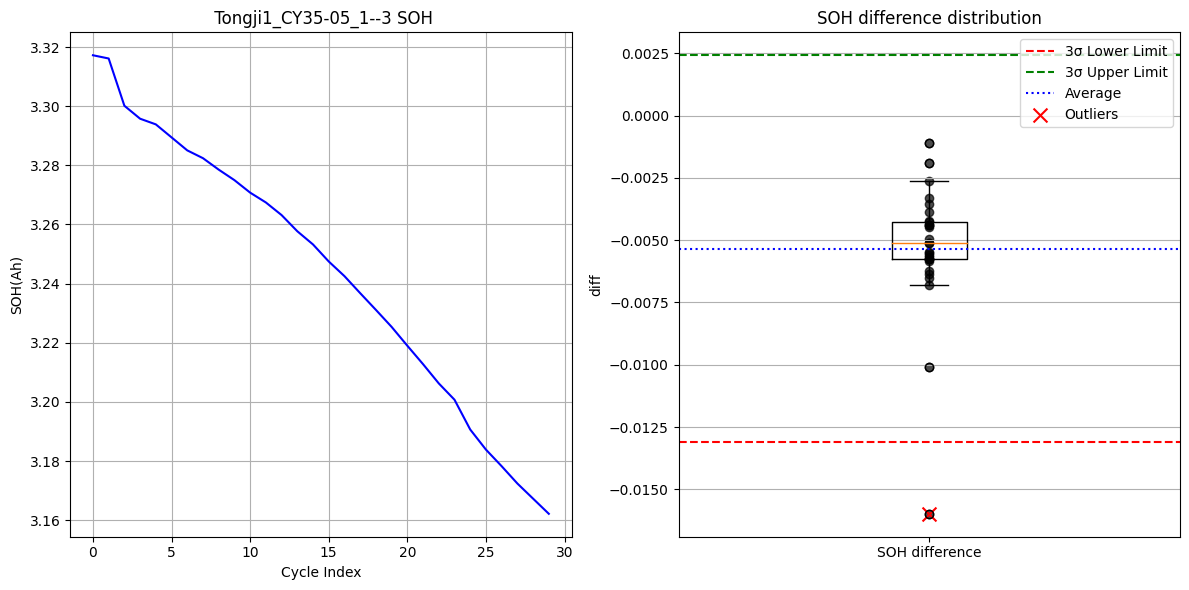

统计信息: {'mean': -0.005346537441027456, 'std': 0.002589843469676993, 'lower_limit': -0.013116067850058435, 'upper_limit': 0.0024229929680035234, 'anomaly_count': 1, 'total_points': 29}


In [4]:
def create_discharge_difference_boxplot(battery):
    """为单个电池创建放电容量差异的箱型图，显示3σ界限"""
    
    # 提取最大放电容量
    discharge_capacities = []
    for cycle in battery.cycle_data:
        if cycle.discharge_capacity_in_Ah is not None and len(cycle.discharge_capacity_in_Ah) > 0:
            discharge_capacities.append(max(cycle.discharge_capacity_in_Ah))
        else:
            discharge_capacities.append(None)
    
    # 移除None值
    valid_capacities = [cap for cap in discharge_capacities if cap is not None]
    
    if len(valid_capacities) < 3:
        print(f"电池 {battery.cell_id} 的有效数据不足，无法创建箱型图")
        return
    
    # 计算容量差异
    diffs = np.diff(valid_capacities)
    
    # 计算3σ界限
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs)
    lower_limit = mean_diff - 3 * std_diff
    upper_limit = mean_diff + 3 * std_diff
    
    # 创建图
    plt.figure(figsize=(12, 6))
    
    # 左侧：容量曲线
    plt.subplot(1, 2, 1)
    plt.plot(range(len(valid_capacities)), valid_capacities, 'b-', label='SOH')
    plt.xlabel('Cycle Index')
    plt.ylabel('SOH(Ah)')
    plt.title(f' {battery.cell_id} SOH')
    plt.grid(True)
    
    # 右侧：箱型图
    plt.subplot(1, 2, 2)
    boxplot = plt.boxplot(diffs, labels=['SOH difference'])
    
    # 在箱型图上叠加散点图，显示所有数据点
    y_position = np.ones(len(diffs))  # 所有点在同一水平位置
    plt.scatter(y_position, diffs, color='black', alpha=0.7)
    
    # 添加3σ线
    plt.axhline(y=lower_limit, color='red', linestyle='--', label='3σ Lower Limit')
    plt.axhline(y=upper_limit, color='green', linestyle='--', label='3σ Upper Limit')
    plt.axhline(y=mean_diff, color='blue', linestyle=':', label='Average')
    
    # 标记异常值
    anomalies = [diff for diff in diffs if diff < lower_limit or diff > upper_limit]
    if anomalies:
        print(f"test {len(anomalies)} outliers")
        anomaly_indices = [i for i, diff in enumerate(diffs) if diff < lower_limit or diff > upper_limit]
        plt.scatter([1] * len(anomaly_indices), [diffs[i] for i in anomaly_indices], 
                   color='red', s=100, marker='x', label='Outliers')
    
    plt.ylabel('diff')
    plt.title('SOH difference distribution')
    plt.grid(True, axis='y')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 返回异常值信息
    return {
        'mean': mean_diff,
        'std': std_diff,
        'lower_limit': lower_limit,
        'upper_limit': upper_limit,
        'anomaly_count': len([d for d in diffs if d < lower_limit or d > upper_limit]),
        'total_points': len(diffs)
    }

# 调用函数展示第一个电池的箱型图
stats = create_discharge_difference_boxplot(all_batteries[0])
print(f"统计信息: {stats}")

In [5]:
def filter_abnormal_capacity_jumps(battery_data, threshold=None):
    """
    过滤相邻循环容量差值过大的异常循环
    """
    # 动态设置阈值
    if threshold is None:
        nominal_cap = getattr(battery_data, 'nominal_capacity_in_Ah', 3.5)
        threshold = max(0.1 * nominal_cap, 0.3)  # 10%标称容量或0.3Ah
    
    processed_battery = copy.deepcopy(battery_data)
    indices_to_remove = set()
    jump_count = 0
    
    # 遍历所有循环
    for i in range(len(processed_battery.cycle_data) - 1):
        current_cycle = processed_battery.cycle_data[i]
        next_cycle = processed_battery.cycle_data[i + 1]
        
        # 获取容量数据
        current_charge = max(current_cycle.charge_capacity_in_Ah) if current_cycle.charge_capacity_in_Ah else None
        next_charge = max(next_cycle.charge_capacity_in_Ah) if next_cycle.charge_capacity_in_Ah else None
        current_discharge = max(current_cycle.discharge_capacity_in_Ah) if current_cycle.discharge_capacity_in_Ah else None
        next_discharge = max(next_cycle.discharge_capacity_in_Ah) if next_cycle.discharge_capacity_in_Ah else None
        
        # 检查跳变
        charge_jump = current_charge and next_charge and abs(current_charge - next_charge) > threshold
        discharge_jump = current_discharge and next_discharge and abs(current_discharge - next_discharge) > threshold
        
        if charge_jump or discharge_jump:
            indices_to_remove.add(i)
            indices_to_remove.add(i + 1)
            jump_count += 1
    
    # 更新数据
    processed_battery.cycle_data = [
        cycle for idx, cycle in enumerate(processed_battery.cycle_data)
        if idx not in indices_to_remove
    ]
    
    # 简化输出
    if jump_count > 0:
        print(f"🔧 {getattr(battery_data, 'cell_id', 'Unknown')}: 检测到 {jump_count} 个容量跳变，删除 {len(indices_to_remove)} 个循环")
    
    return processed_battery

def detect_and_handle_anomalies(all_batteries, visualize=True):
    """检测并处理异常值"""
    print(f"🔍 开始异常值检测，共 {len(all_batteries)} 个电池...")
    
    # 容量跳变预处理
    preprocessed_batteries = []
    total_jumps = 0
    
    for i, battery in enumerate(all_batteries):
        preprocessed = filter_abnormal_capacity_jumps(battery)
        preprocessed_batteries.append(preprocessed)
        
        # 统计删除的循环数
        original_cycles = len(battery.cycle_data)
        processed_cycles = len(preprocessed.cycle_data)
        if original_cycles != processed_cycles:
            total_jumps += (original_cycles - processed_cycles)
        
        # 每65个电池显示一次进度
        if (i + 1) % 65 == 0 or (i + 1) == len(all_batteries):
            print(f"📊 预处理进度: {i + 1}/{len(all_batteries)}")
    
    print(f"✅ 容量跳变预处理完成，共删除 {total_jumps} 个异常循环")
    
    # 3σ异常值检测
    return detect_and_handle_anomalies_original(preprocessed_batteries, visualize)

def detect_and_handle_anomalies_original(all_batteries, visualize=True):
    """3σ异常值检测（简化版）"""
    processed_batteries = copy.deepcopy(all_batteries)
    before_after_data = []
    total_anomalies = 0
    
    for i, battery in enumerate(all_batteries):
        # 提取有效容量数据
        discharge_capacities = []
        for cycle in battery.cycle_data:
            if cycle.discharge_capacity_in_Ah and len(cycle.discharge_capacity_in_Ah) > 0:
                discharge_capacities.append(max(cycle.discharge_capacity_in_Ah))
        
        if len(discharge_capacities) < 3:
            continue
        
        # 3σ检测
        diffs = np.diff(discharge_capacities)
        mean_diff = np.mean(diffs)
        std_diff = np.std(diffs)
        lower_limit = mean_diff - 3 * std_diff
        upper_limit = mean_diff + 3 * std_diff
        
        anomaly_indices = []
        for j in range(len(diffs)):
            if diffs[j] < lower_limit or diffs[j] > upper_limit:
                anomaly_indices.append(j+1)
        
        # 处理异常值
        if anomaly_indices:
            total_anomalies += len(anomaly_indices)
            smoothed_capacities = medfilt(discharge_capacities, 5)
            
            for idx in anomaly_indices:
                if idx < len(discharge_capacities):
                    discharge_capacities[idx] = smoothed_capacities[idx]
            
            # 更新数据
            valid_idx = 0
            for cycle in processed_batteries[i].cycle_data:
                if cycle.discharge_capacity_in_Ah and len(cycle.discharge_capacity_in_Ah) > 0:
                    max_idx = np.argmax(cycle.discharge_capacity_in_Ah)
                    cycle.discharge_capacity_in_Ah[max_idx] = discharge_capacities[valid_idx]
                    valid_idx += 1
        
        # 记录可视化数据（只保留前5个电池）
        if len(before_after_data) < 5:
            before_after_data.append((battery.cell_id, 
                                    [max(cycle.discharge_capacity_in_Ah) for cycle in battery.cycle_data if cycle.discharge_capacity_in_Ah], 
                                    discharge_capacities, 
                                    anomaly_indices))
    
    print(f"🎯 3σ异常值检测完成，共处理 {total_anomalies} 个异常点")
    
    # 可视化（只显示前5个电池）
    if visualize and before_after_data:
        visualize_anomaly_detection(before_after_data)
    
    return processed_batteries

def visualize_anomaly_detection(before_after_data):
    """简化的可视化函数"""
    num_batteries = min(len(before_after_data), 3)  # 最多显示3个电池
    fig, axes = plt.subplots(num_batteries, 2, figsize=(15, 4*num_batteries))
    
    if num_batteries == 1:
        axes = np.array([axes])
    
    for i in range(num_batteries):
        cell_id, before, after, anomaly_indices = before_after_data[i]
        
        # 异常点检测图
        axes[i, 0].plot(before, 'b-', label='原始数据')
        if anomaly_indices:
            axes[i, 0].scatter(anomaly_indices, [before[idx] for idx in anomaly_indices], 
                              color='red', s=50, label='异常点')
        axes[i, 0].set_title(f'{cell_id} - 异常点检测')
        axes[i, 0].legend()
        
        # 处理前后对比
        axes[i, 1].plot(before, 'b-', alpha=0.7, label='处理前')
        axes[i, 1].plot(after, 'g-', label='处理后')
        axes[i, 1].set_title(f'{cell_id} - 处理对比')
        axes[i, 1].legend()
    
    plt.tight_layout()
    plt.show()

In [6]:
def remove_first_cycle_simple(processed_batteries):
    """
    最简单的内存友好版本
    """
    print(f"🔧 删除第一个循环...")
    
    success_count = 0
    for battery in processed_batteries:
        try:
            if len(battery.cycle_data) > 1:
                battery.cycle_data.pop(0)  # 删除第一个元素
                success_count += 1
        except:
            pass
    
    print(f"✅ 完成! 成功处理 {success_count} 个电池")
    return processed_batteries

🔍 开始异常值检测，共 66 个电池...
🔧 Tongji1_CY35-05_1--2: 检测到 2 个容量跳变，删除 3 个循环
🔧 Tongji1_CY25-05_1--10: 检测到 2 个容量跳变，删除 3 个循环
🔧 Tongji1_CY45-05_1--18: 检测到 2 个容量跳变，删除 3 个循环
🔧 Tongji1_CY45-05_1--24: 检测到 2 个容量跳变，删除 3 个循环
🔧 Tongji1_CY45-05_1--19: 检测到 2 个容量跳变，删除 3 个循环
🔧 Tongji1_CY45-05_1--26: 检测到 2 个容量跳变，删除 3 个循环
🔧 Tongji1_CY45-05_1--23: 检测到 2 个容量跳变，删除 3 个循环
🔧 Tongji1_CY45-05_1--20: 检测到 2 个容量跳变，删除 3 个循环
🔧 Tongji1_CY45-05_1--15: 检测到 2 个容量跳变，删除 3 个循环
🔧 Tongji1_CY45-05_1--16: 检测到 4 个容量跳变，删除 6 个循环
📊 预处理进度: 65/66
📊 预处理进度: 66/66
✅ 容量跳变预处理完成，共删除 33 个异常循环
🎯 3σ异常值检测完成，共处理 289 个异常点


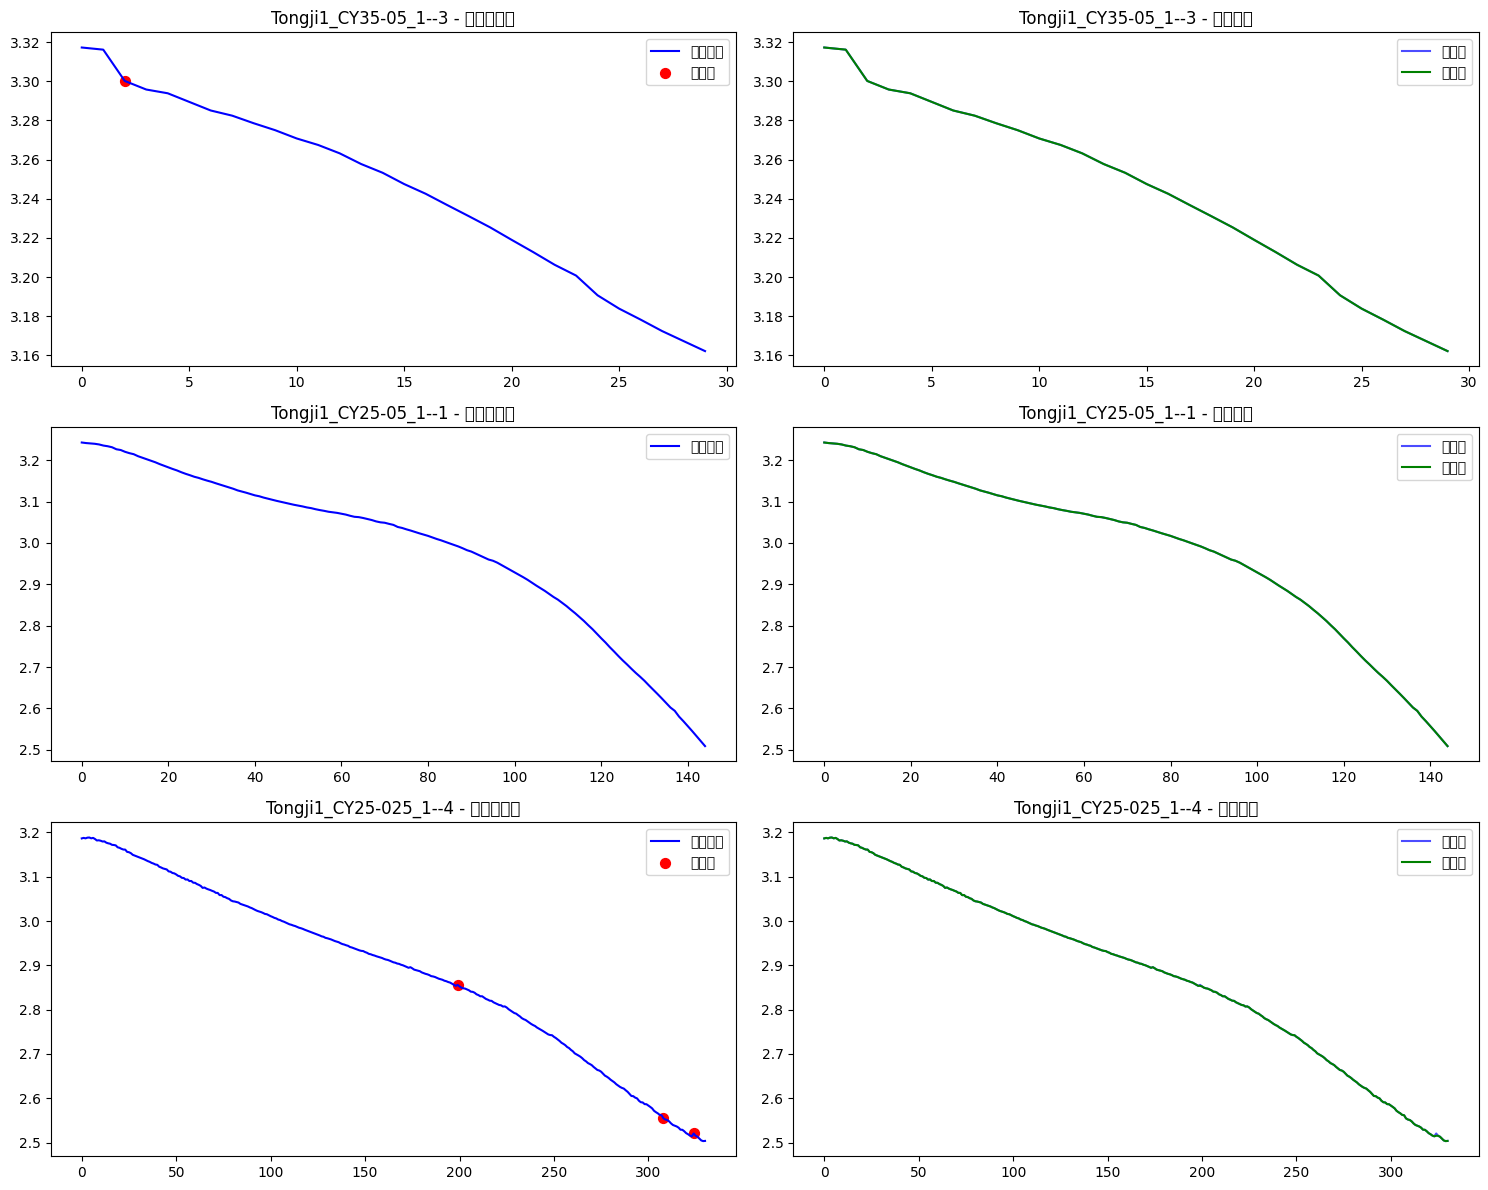

In [7]:
# 使用新的处理流程（3西格玛+包含容量跳变过滤）
processed_batteries = detect_and_handle_anomalies(all_batteries)

In [8]:
# 删除所有电池的第一个循环
processed_batteries = remove_first_cycle_simple(processed_batteries)

🔧 删除第一个循环...
✅ 完成! 成功处理 66 个电池


<Figure size 1400x800 with 0 Axes>

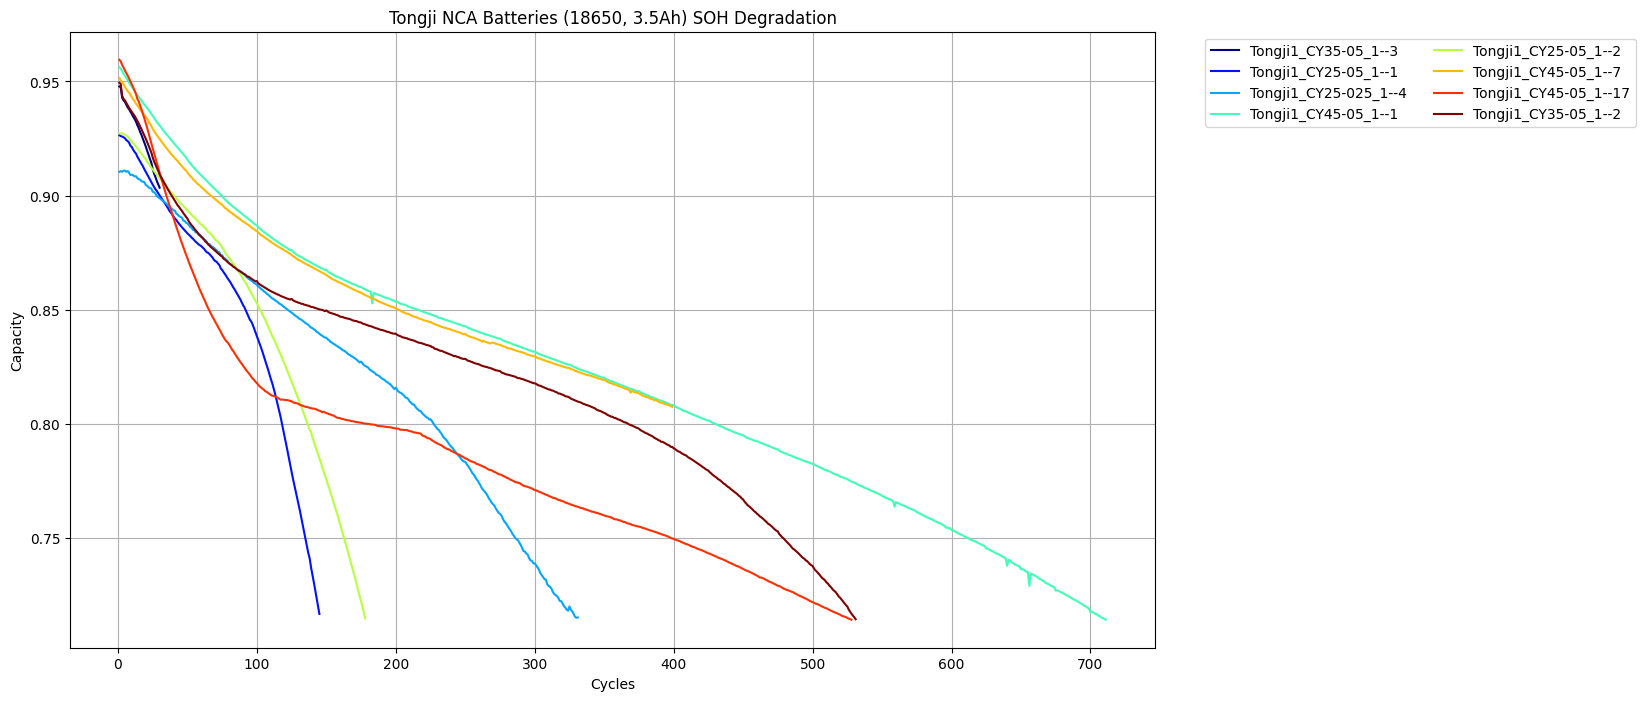

成功绘制了目标NCA电池组的容量衰减曲线: 8个电池
选中的NCA电池:
  1. Tongji1_CY35-05_1--3.pkl - 容量: 3.5Ah
  2. Tongji1_CY25-05_1--1.pkl - 容量: 3.5Ah
  3. Tongji1_CY25-025_1--4.pkl - 容量: 3.5Ah
  4. Tongji1_CY45-05_1--1.pkl - 容量: 3.5Ah
  5. Tongji1_CY25-05_1--2.pkl - 容量: 3.5Ah
  6. Tongji1_CY45-05_1--7.pkl - 容量: 3.5Ah
  7. Tongji1_CY45-05_1--17.pkl - 容量: 3.5Ah
  8. Tongji1_CY35-05_1--2.pkl - 容量: 3.5Ah
图像已保存到: /kaggle/working/pictures/Tongji_NCA_Batteries_SOH_degradation.png


<Figure size 1600x1000 with 0 Axes>

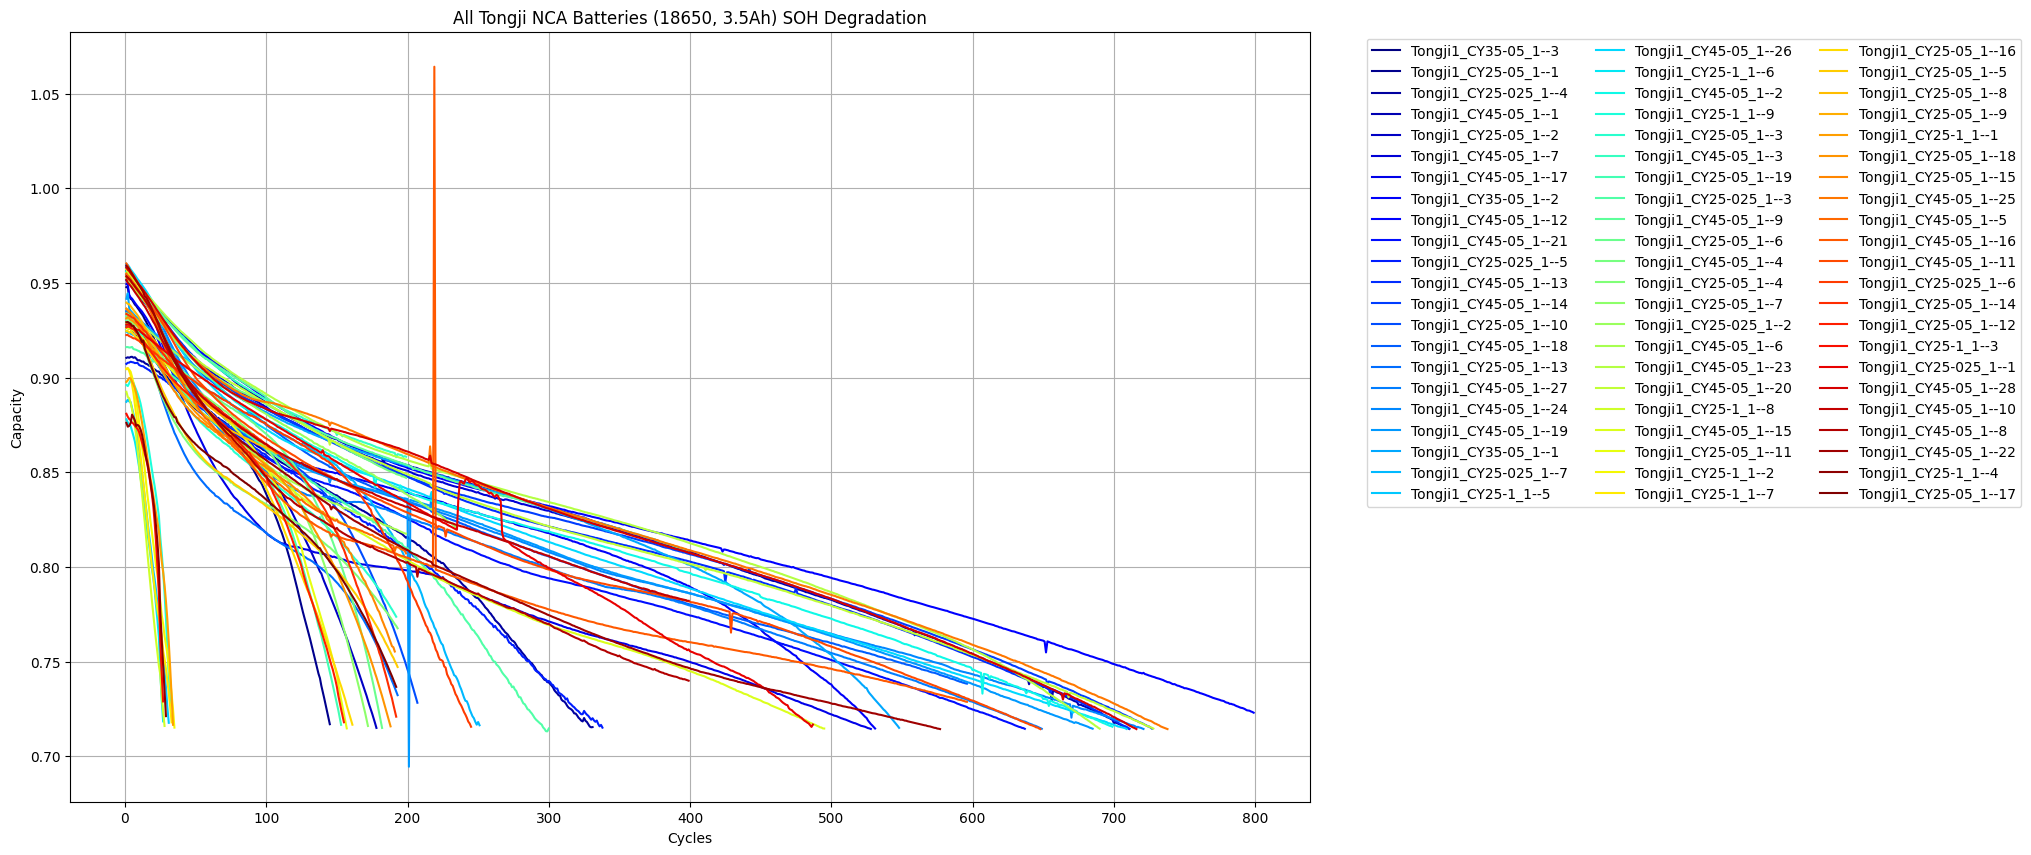

成功绘制了所有 66 个NCA电池的容量衰减曲线
图像已保存到: /kaggle/working/pictures/All_Tongji_NCA_Batteries_SOH_degradation.png

📊 同济大学NCA电池数据统计:
总数: 66 个NCA电池
类型: 18650型 NCA电池
标称容量: 3.5Ah
平均循环次数: 342.2
最大循环次数: 799
最小循环次数: 27


In [9]:
if nca_batteries:  # 使用我们之前分类好的NCA电池数据
    # 从NCA电池信息中提取电池对象
    nca_battery_objects = [info['battery'] for info in nca_batteries if info['battery'] is not None]
    
    # 选择一些代表性的NCA电池进行分析（可以选择前几个或者随机选择）
    # 这里我们选择前8个NCA电池作为目标电池
    target_nca_batteries = nca_battery_objects[:8]
    
    # 确保输出目录存在
    output_dir = '/kaggle/working/pictures'
    os.makedirs(output_dir, exist_ok=True)
    
    # 绘制目标NCA电池图表
    if target_nca_batteries:
        plt.figure(figsize=(14, 8))
        plot_capacity_degradation(target_nca_batteries, 
                                 figsize=(14, 8), 
                                 normalize=True, 
                                 title='Tongji NCA Batteries (18650, 3.5Ah) SOH Degradation',
                                 n_legend_cols=2)
        # 保存图像
        target_output_path = os.path.join(output_dir, 'Tongji_NCA_Batteries_SOH_degradation.png')
        plt.savefig(target_output_path, dpi=300, bbox_inches='tight')
        # 显示图像
        plt.show()
        
        # 显示选中的NCA电池信息
        print(f"成功绘制了目标NCA电池组的容量衰减曲线: {len(target_nca_batteries)}个电池")
        print("选中的NCA电池:")
        for i, info in enumerate(nca_batteries[:8]):
            print(f"  {i+1}. {info['filename']} - 容量: {info['nominal_capacity']}Ah")
        print(f"图像已保存到: {target_output_path}")
    
    # 可选：绘制所有NCA电池的对比图
    if len(nca_battery_objects) > 8:
        plt.figure(figsize=(16, 10))
        plot_capacity_degradation(nca_battery_objects, 
                                 figsize=(16, 10), 
                                 normalize=True, 
                                 title='All Tongji NCA Batteries (18650, 3.5Ah) SOH Degradation',
                                 n_legend_cols=3)
        all_nca_output_path = os.path.join(output_dir, 'All_Tongji_NCA_Batteries_SOH_degradation.png')
        plt.savefig(all_nca_output_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"成功绘制了所有 {len(nca_battery_objects)} 个NCA电池的容量衰减曲线")
        print(f"图像已保存到: {all_nca_output_path}")
    
    # 显示NCA电池统计信息
    print(f"\n📊 同济大学NCA电池数据统计:")
    print(f"总数: {len(nca_battery_objects)} 个NCA电池")
    print(f"类型: 18650型 NCA电池")
    print(f"标称容量: 3.5Ah")
    
    # 计算一些基本统计信息
    if nca_battery_objects:
        cycle_counts = []
        for battery in nca_battery_objects:
            if hasattr(battery, 'cycle_data') and battery.cycle_data:
                cycle_counts.append(len(battery.cycle_data))
        
        if cycle_counts:
            print(f"平均循环次数: {sum(cycle_counts)/len(cycle_counts):.1f}")
            print(f"最大循环次数: {max(cycle_counts)}")
            print(f"最小循环次数: {min(cycle_counts)}")

else:
    print("没有成功加载任何NCA电池数据")
    print("请确保已经运行了NCA电池分类代码")

# 三、基本ICA处理 

## 3.1创建目标电池

In [10]:
# 创建目标NCA电池列表
target_nca_batteries = []

# 从NCA电池中选择一些代表性的电池进行详细分析
# 我们可以选择不同充电条件下的电池作为目标
target_patterns = [
    'Tongji1_CY25-05_1--1',   # 25°C, 0.5C充电
    'Tongji1_CY25-05_1--2',   # 25°C, 0.5C充电  
    'Tongji1_CY35-05_1--1',   # 35°C, 0.5C充电
    'Tongji1_CY45-05_1--1',   # 45°C, 0.5C充电
    'Tongji1_CY25-025_1--4',  # 25°C, 0.25C充电
    'Tongji1_CY25-1_1--5'     # 25°C, 1C充电
]

# 通过文件名模式精确查找目标NCA电池
if nca_batteries:  # 使用我们之前分类的NCA电池数据
    for battery_info in nca_batteries:
        filename = battery_info['filename']
        # 移除.pkl扩展名进行匹配
        filename_base = filename.replace('.pkl', '')
        
        if filename_base in target_patterns:
            target_nca_batteries.append(battery_info)

# 检查查找结果
if not target_nca_batteries:
    print("未找到任何目标NCA电池")
    print("可用的NCA电池文件:")
    for i, battery_info in enumerate(nca_batteries[:10]):  # 显示前10个
        print(f"  {i+1}. {battery_info['filename']}")
else:
    # 打印找到的电池信息
    found_patterns = [info['filename'].replace('.pkl', '') for info in target_nca_batteries]
    print(f"成功找到 {len(target_nca_batteries)} 个目标NCA电池:")
    for pattern in found_patterns:
        print(f"  - {pattern}")
    
    # 检查缺失的电池
    missing_patterns = [pattern for pattern in target_patterns 
                       if pattern not in found_patterns]
    if missing_patterns:
        print(f"\n警告: 未找到以下目标电池:")
        for pattern in missing_patterns:
            print(f"  - {pattern}")
    
    # 显示每个电池的详细信息
    print("\n===== 目标NCA电池详细信息 =====")
    for i, battery_info in enumerate(target_nca_batteries):
        battery = battery_info['battery']
        filename = battery_info['filename']
        
        print(f"\n----- NCA电池 {i+1}: {filename} -----")
        
        # 解析文件名中的测试条件
        if 'CY25' in filename:
            temp = "25°C"
        elif 'CY35' in filename:
            temp = "35°C"
        elif 'CY45' in filename:
            temp = "45°C"
        else:
            temp = "未知温度"
            
        if 'CY25-025' in filename:
            charge_rate = "0.25C"
        elif 'CY25-05' in filename or 'CY35-05' in filename or 'CY45-05' in filename:
            charge_rate = "0.5C"
        elif 'CY25-1' in filename:
            charge_rate = "1C"
        else:
            charge_rate = "未知充电倍率"
        
        print(f"测试条件: {temp}, {charge_rate}充电")
        print(f"标称容量: {battery_info['nominal_capacity']}Ah")
        print(f"电池类型: 18650型 NCA电池")
        
        # 循环数据信息
        if hasattr(battery, 'cycle_data') and battery.cycle_data:
            cycle_count = len(battery.cycle_data)
            print(f"循环次数: {cycle_count}")
            
            # 直接计算SOH信息（不依赖外部函数）
            try:
                nominal_capacity = getattr(battery, 'nominal_capacity_in_Ah', 3.5)
                soh_values = []
                
                for cycle_idx, cycle_obj in enumerate(battery.cycle_data):
                    # 尝试获取放电容量
                    capacity = None
                    capacity_attrs = ['discharge_capacity', 'capacity', 'discharge_capacity_in_Ah', 
                                    'capacity_in_Ah', 'actual_capacity', 'measured_capacity']
                    
                    for attr in capacity_attrs:
                        if hasattr(cycle_obj, attr):
                            capacity_data = getattr(cycle_obj, attr)
                            
                            if isinstance(capacity_data, (list, tuple)) and len(capacity_data) > 0:
                                capacity = capacity_data[-1]
                            elif isinstance(capacity_data, (int, float)):
                                capacity = capacity_data
                            
                            if capacity is not None and capacity > 0:
                                break
                    
                    if capacity is not None and capacity > 0:
                        soh = float(capacity) / float(nominal_capacity)
                        soh_values.append(soh)
                
                if soh_values:
                    soh_start = soh_values[0] * 100
                    soh_end = soh_values[-1] * 100
                    soh_degradation = soh_start - soh_end
                    
                    print(f"SOH变化: {soh_start:.2f}% → {soh_end:.2f}% (衰减: {soh_degradation:.2f}%)")
                    print(f"有效SOH数据点: {len(soh_values)} 个")
                else:
                    print("未能提取SOH数据")
                    
            except Exception as e:
                print(f"SOH计算出错: {e}")
        else:
            print("无循环数据")
        
        print("-" * 80)  # 分隔线

# 如果没有找到目标电池，提供备选方案
if not target_nca_batteries and nca_batteries:
    print("\n🔄 使用前6个NCA电池作为备选目标:")
    target_nca_batteries = nca_batteries[:6]
    
    for i, battery_info in enumerate(target_nca_batteries):
        print(f"  {i+1}. {battery_info['filename']} - {battery_info['nominal_capacity']}Ah")

成功找到 6 个目标NCA电池:
  - Tongji1_CY25-05_1--1
  - Tongji1_CY25-025_1--4
  - Tongji1_CY45-05_1--1
  - Tongji1_CY25-05_1--2
  - Tongji1_CY35-05_1--1
  - Tongji1_CY25-1_1--5

===== 目标NCA电池详细信息 =====

----- NCA电池 1: Tongji1_CY25-05_1--1.pkl -----
测试条件: 25°C, 0.5C充电
标称容量: 3.5Ah
电池类型: 18650型 NCA电池
循环次数: 145
SOH变化: 92.64% → 71.69% (衰减: 20.96%)
有效SOH数据点: 145 个
--------------------------------------------------------------------------------

----- NCA电池 2: Tongji1_CY25-025_1--4.pkl -----
测试条件: 25°C, 0.25C充电
标称容量: 3.5Ah
电池类型: 18650型 NCA电池
循环次数: 331
SOH变化: 91.04% → 71.54% (衰减: 19.50%)
有效SOH数据点: 331 个
--------------------------------------------------------------------------------

----- NCA电池 3: Tongji1_CY45-05_1--1.pkl -----
测试条件: 45°C, 0.5C充电
标称容量: 3.5Ah
电池类型: 18650型 NCA电池
循环次数: 711
SOH变化: 95.62% → 71.44% (衰减: 24.18%)
有效SOH数据点: 711 个
--------------------------------------------------------------------------------

----- NCA电池 4: Tongji1_CY25-05_1--2.pkl -----
测试条件: 25°C, 0.5C充电
标称容量: 3.5Ah
电池类型: 18

## 3.2调参

🎯 同济大学NCA电池ICA分析器已就绪!
📋 使用方法 (兼容您的all_batteries数据):
   1. analyze_tongji_nca_battery(all_batteries[0], 100)
   2. batch_analyze_tongji_nca_batteries(all_batteries, [50,100,200])
   3. get_nca_health_indicators(all_batteries[0])
✅ 同济大学NCA电池ICA分析器已初始化
🔋 专为NCA电池优化 (Tongji1 dataset)
📊 电压范围: 2.5V - 4.3V
循环 100 不存在
✅ 同济大学NCA电池ICA分析器已初始化
🔋 专为NCA电池优化 (Tongji1 dataset)
📊 电压范围: 2.5V - 4.3V
🔋 开始分析 5 个NCA电池...

📊 分析电池 Tongji1_CY35-05_1--3 (1/5)
🔋 开始批量分析NCA电池 4 个循环...

=== 同济大学NCA电池ICA分析参数配置 ===
🔋 电池类型: NCA (同济大学dataset1 - Tongji1)
📊 电压范围: 2.5V - 4.3V (NCA专用)
📈 电压网格点数: 130
🔢 差分间隔: 22 (NCA优化)
🌊 高斯滤波: sigma=4.5, 层数=3
🎯 电压容差: 0.0005V
📊 IQR倍数: 2.8
⛰️ 峰值检测: 阈值=0.05, 距离=8
🔀 峰值合并: 启用
✨ 增强平滑: 启用
循环 50 不存在
循环 100 不存在
循环 200 不存在
循环 300 不存在

📊 分析电池 Tongji1_CY25-05_1--1 (2/5)
🔋 开始批量分析NCA电池 4 个循环...

=== 同济大学NCA电池ICA分析参数配置 ===
🔋 电池类型: NCA (同济大学dataset1 - Tongji1)
📊 电压范围: 2.5V - 4.3V (NCA专用)
📈 电压网格点数: 130
🔢 差分间隔: 22 (NCA优化)
🌊 高斯滤波: sigma=4.5, 层数=3
🎯 电压容差: 0.0005V
📊 IQR倍数: 2.8
⛰️ 峰值检测: 阈值=0.05, 距离=8
🔀 峰值合并: 启用
✨ 

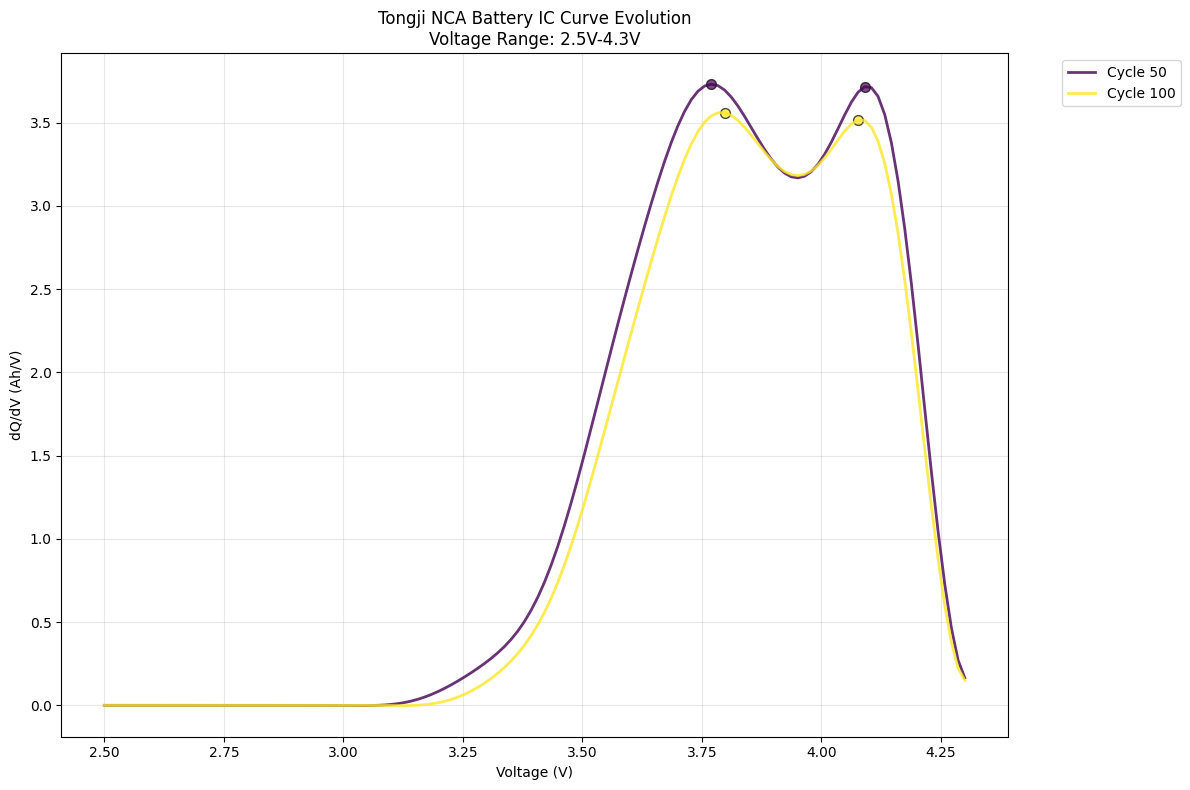


📊 分析电池 Tongji1_CY25-025_1--4 (3/5)
🔋 开始批量分析NCA电池 4 个循环...

=== 同济大学NCA电池ICA分析参数配置 ===
🔋 电池类型: NCA (同济大学dataset1 - Tongji1)
📊 电压范围: 2.5V - 4.3V (NCA专用)
📈 电压网格点数: 130
🔢 差分间隔: 22 (NCA优化)
🌊 高斯滤波: sigma=4.5, 层数=3
🎯 电压容差: 0.0005V
📊 IQR倍数: 2.8
⛰️ 峰值检测: 阈值=0.05, 距离=8
🔀 峰值合并: 启用
✨ 增强平滑: 启用

=== Tongji1_CY25-025_1--4 NCA电池循环 50 分析结果 ===
检测到 2 个峰值
最大dQ/dV: 3.7964 Ah/V
IC曲线面积: 2.5889
主要峰值:
  峰值 1: 3.728V, 3.7902 Ah/V
  峰值 2: 3.951V, 3.7964 Ah/V

=== Tongji1_CY25-025_1--4 NCA电池循环 100 分析结果 ===
检测到 2 个峰值
最大dQ/dV: 3.7935 Ah/V
IC曲线面积: 2.4848
主要峰值:
  峰值 1: 3.756V, 3.6923 Ah/V
  峰值 2: 3.937V, 3.7935 Ah/V

=== Tongji1_CY25-025_1--4 NCA电池循环 200 分析结果 ===
检测到 2 个峰值
最大dQ/dV: 3.7181 Ah/V
IC曲线面积: 2.4436
主要峰值:
  峰值 1: 3.770V, 3.5805 Ah/V
  峰值 2: 3.937V, 3.7181 Ah/V

=== Tongji1_CY25-025_1--4 NCA电池循环 300 分析结果 ===
检测到 1 个峰值
最大dQ/dV: 3.6152 Ah/V
IC曲线面积: 2.1492
主要峰值:
  峰值 1: 3.965V, 3.6152 Ah/V


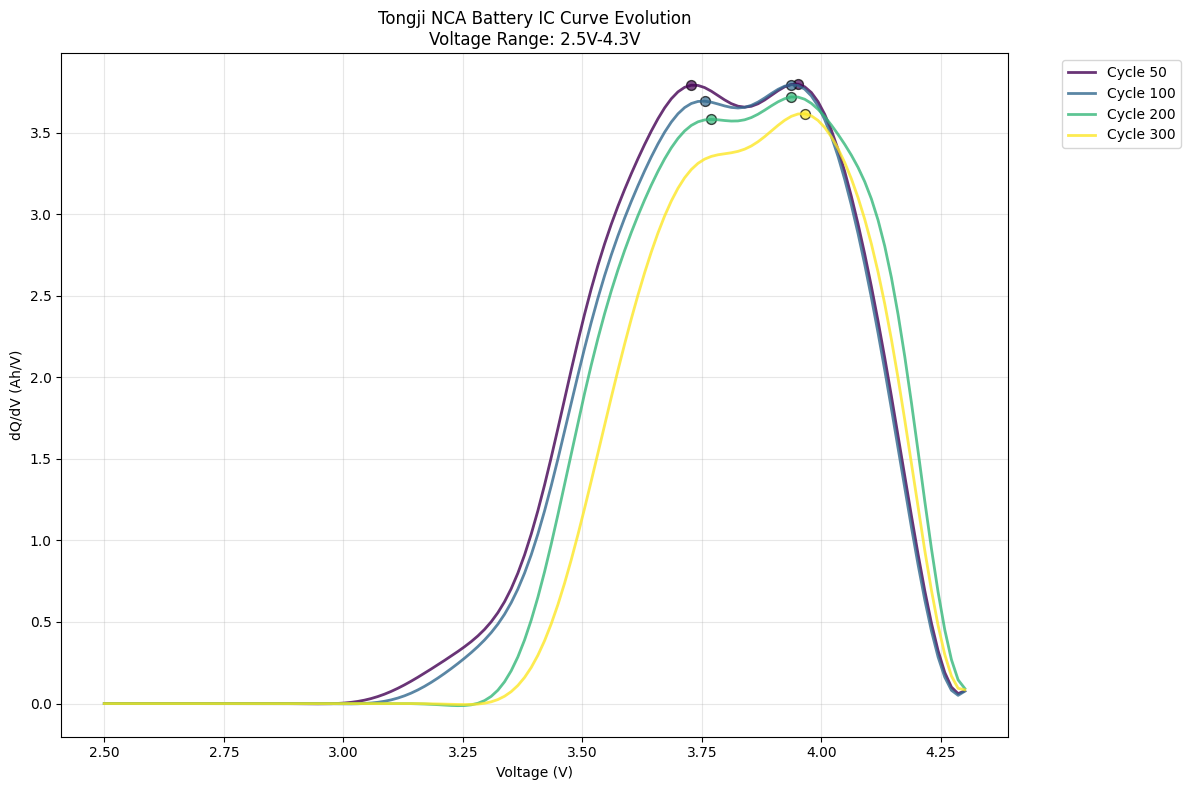


📊 分析电池 Tongji1_CY45-05_1--1 (4/5)
🔋 开始批量分析NCA电池 4 个循环...

=== 同济大学NCA电池ICA分析参数配置 ===
🔋 电池类型: NCA (同济大学dataset1 - Tongji1)
📊 电压范围: 2.5V - 4.3V (NCA专用)
📈 电压网格点数: 130
🔢 差分间隔: 22 (NCA优化)
🌊 高斯滤波: sigma=4.5, 层数=3
🎯 电压容差: 0.0005V
📊 IQR倍数: 2.8
⛰️ 峰值检测: 阈值=0.05, 距离=8
🔀 峰值合并: 启用
✨ 增强平滑: 启用

=== Tongji1_CY45-05_1--1 NCA电池循环 50 分析结果 ===
检测到 2 个峰值
最大dQ/dV: 3.7986 Ah/V
IC曲线面积: 2.6533
主要峰值:
  峰值 1: 3.756V, 3.7986 Ah/V
  峰值 2: 4.007V, 3.6679 Ah/V

=== Tongji1_CY45-05_1--1 NCA电池循环 100 分析结果 ===
检测到 2 个峰值
最大dQ/dV: 3.6939 Ah/V
IC曲线面积: 2.6520
主要峰值:
  峰值 1: 3.770V, 3.6449 Ah/V
  峰值 2: 4.049V, 3.6939 Ah/V

=== Tongji1_CY45-05_1--1 NCA电池循环 200 分析结果 ===
检测到 2 个峰值
最大dQ/dV: 4.0187 Ah/V
IC曲线面积: 2.5876
主要峰值:
  峰值 1: 3.784V, 3.5342 Ah/V
  峰值 2: 4.105V, 4.0187 Ah/V

=== Tongji1_CY45-05_1--1 NCA电池循环 300 分析结果 ===
检测到 2 个峰值
最大dQ/dV: 3.6595 Ah/V
IC曲线面积: 2.3228
主要峰值:
  峰值 1: 3.784V, 3.4695 Ah/V
  峰值 2: 4.021V, 3.6595 Ah/V


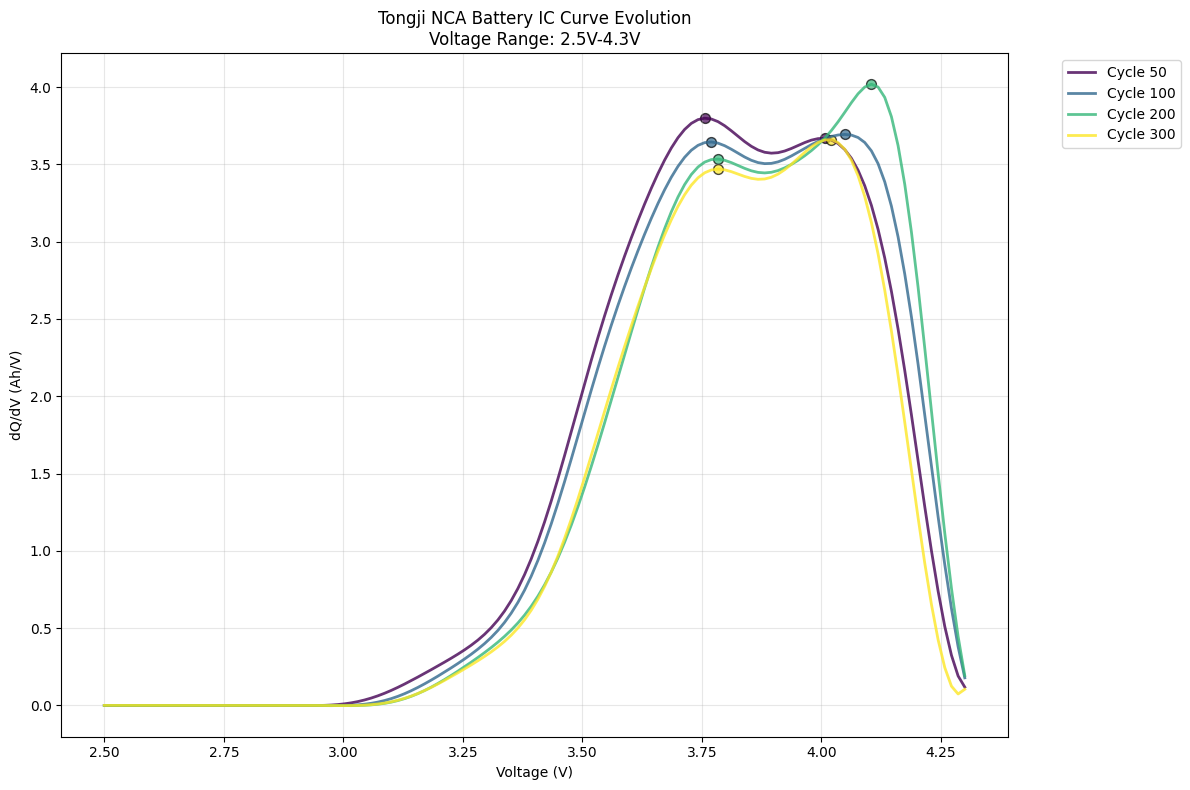


📊 分析电池 Tongji1_CY25-05_1--2 (5/5)
🔋 开始批量分析NCA电池 4 个循环...

=== 同济大学NCA电池ICA分析参数配置 ===
🔋 电池类型: NCA (同济大学dataset1 - Tongji1)
📊 电压范围: 2.5V - 4.3V (NCA专用)
📈 电压网格点数: 130
🔢 差分间隔: 22 (NCA优化)
🌊 高斯滤波: sigma=4.5, 层数=3
🎯 电压容差: 0.0005V
📊 IQR倍数: 2.8
⛰️ 峰值检测: 阈值=0.05, 距离=8
🔀 峰值合并: 启用
✨ 增强平滑: 启用

=== Tongji1_CY25-05_1--2 NCA电池循环 50 分析结果 ===
检测到 2 个峰值
最大dQ/dV: 3.7856 Ah/V
IC曲线面积: 2.4075
主要峰值:
  峰值 1: 3.770V, 3.7856 Ah/V
  峰值 2: 4.049V, 3.4785 Ah/V

=== Tongji1_CY25-05_1--2 NCA电池循环 100 分析结果 ===
检测到 2 个峰值
最大dQ/dV: 3.6051 Ah/V
IC曲线面积: 2.1223
主要峰值:
  峰值 1: 3.784V, 3.6051 Ah/V
  峰值 2: 4.007V, 3.3320 Ah/V
循环 200 不存在
循环 300 不存在


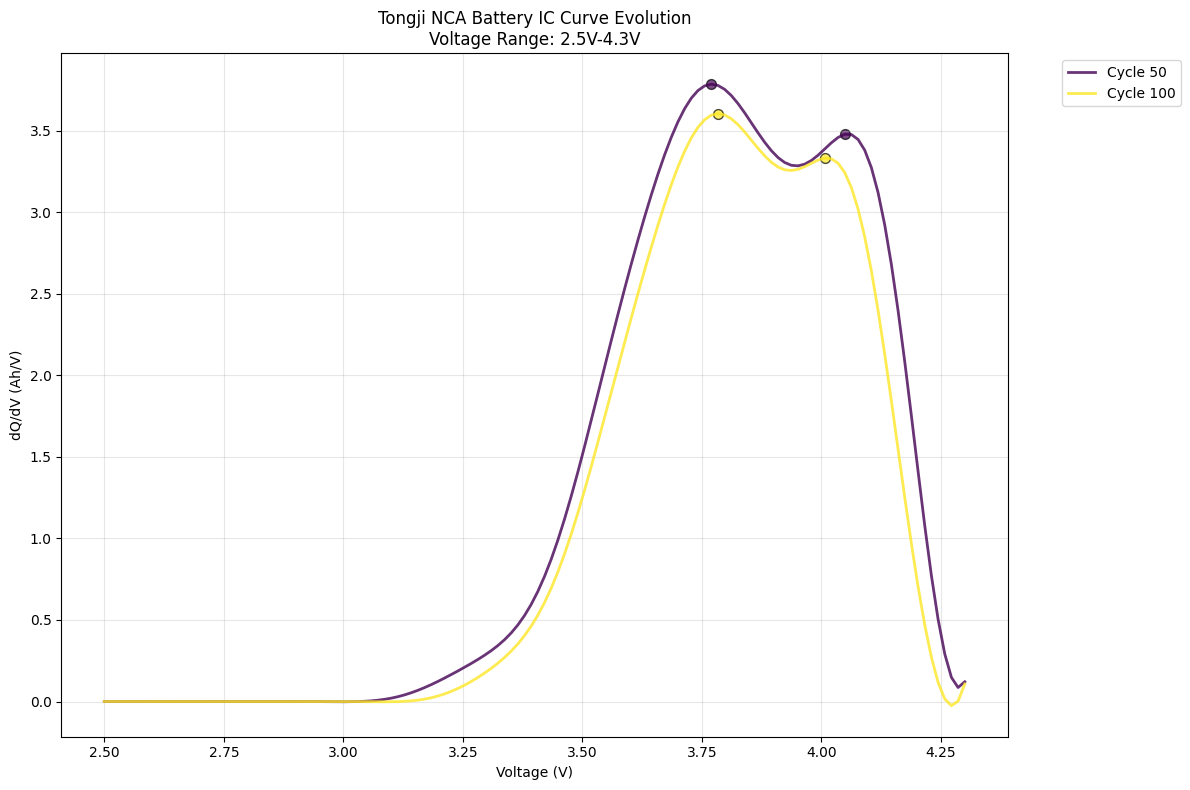

⏳ 已完成 5/5 个电池的分析
✅ 同济大学NCA电池ICA分析器已初始化
🔋 专为NCA电池优化 (Tongji1 dataset)
📊 电压范围: 2.5V - 4.3V

=== Tongji1_CY35-05_1--3 NCA电池循环 10 分析结果 ===
检测到 2 个峰值
最大dQ/dV: 3.9122 Ah/V
IC曲线面积: 2.6788
主要峰值:
  峰值 1: 3.756V, 3.9122 Ah/V
  峰值 2: 4.035V, 3.5869 Ah/V

=== Tongji1_CY35-05_1--3 NCA电池循环 11 分析结果 ===
检测到 2 个峰值
最大dQ/dV: 3.8733 Ah/V
IC曲线面积: 2.5962
主要峰值:
  峰值 1: 3.756V, 3.8733 Ah/V
  峰值 2: 4.035V, 3.6045 Ah/V

=== Tongji1_CY35-05_1--3 NCA电池循环 12 分析结果 ===
检测到 2 个峰值
最大dQ/dV: 3.8752 Ah/V
IC曲线面积: 2.6798
主要峰值:
  峰值 1: 3.756V, 3.8752 Ah/V
  峰值 2: 4.035V, 3.6163 Ah/V

=== Tongji1_CY35-05_1--3 NCA电池循环 13 分析结果 ===
检测到 2 个峰值
最大dQ/dV: 3.9235 Ah/V
IC曲线面积: 2.6877
主要峰值:
  峰值 1: 3.756V, 3.9235 Ah/V
  峰值 2: 4.049V, 3.6311 Ah/V

=== Tongji1_CY35-05_1--3 NCA电池循环 14 分析结果 ===
检测到 2 个峰值
最大dQ/dV: 3.9001 Ah/V
IC曲线面积: 2.6716
主要峰值:
  峰值 1: 3.756V, 3.9001 Ah/V
  峰值 2: 4.035V, 3.5889 Ah/V

=== Tongji1_CY35-05_1--3 NCA电池循环 15 分析结果 ===
检测到 2 个峰值
最大dQ/dV: 3.8287 Ah/V
IC曲线面积: 2.6574
主要峰值:
  峰值 1: 3.756V, 3.8287 Ah/V
  峰值 2: 4.035V,

In [11]:
# ===================================================================
# 同济大学NCA电池ICA分析器 - 完整版本
# 专门适配同济大学dataset1 NCA电池数据 (Tongji1_开头的文件)
# 兼容您的all_batteries数据格式
# ===================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
from typing import Tuple, List, Optional, Dict
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体和图表样式
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('default')

class TongjiNCAConfig:
    """同济大学NCA电池专用ICA分析配置类"""
    def __init__(self, 
                 # NCA电池专用电压范围
                 voltage_min: float = 2.5,          # NCA电池下限
                 voltage_max: float = 4.3,          # NCA电池上限
                 voltage_points: int = 130,         # 增加点数适应更宽电压范围
                 
                 # NCA电池优化的差分参数
                 n_diff: int = 22,                  # 增加差分间隔适应NCA特性
                 
                 # NCA电池优化的滤波参数
                 gaussian_sigma: float = 4.5,       # 增强滤波强度
                 gaussian_layers: int = 3,          # 增加滤波层数
                 enable_filtering: bool = True,
                 
                 # NCA电池优化的数据处理参数
                 voltage_tolerance: float = 0.0005, # 适合NCA的电压容差
                 iqr_multiplier: float = 2.8,       # 更严格的异常值过滤
                 median_threshold_multiplier: float = 6.0,  # 适中的中值限制
                 
                 # NCA电池优化的峰值检测参数
                 peak_height_threshold: float = 0.05,  # 降低峰值检测阈值
                 peak_distance: int = 8,             # 增加峰值间距
                 
                 # 其他参数
                 analysis_mode: str = "charge",
                 
                 # 峰值合并相关参数（针对NCA优化）
                 enable_peak_merging: bool = True,   # 默认启用峰值合并
                 peak_merge_threshold: float = 0.09, # NCA电池合并阈值
                 peak_merge_weight: float = 0.88,    # 合并权重
                 peak_merge_smooth_width: int = 6,   # 平滑宽度
                 peak_merge_gaussian_ratio: float = 0.35,
                 
                 # 增强平滑相关参数（针对NCA优化）
                 enable_enhanced_smoothing: bool = True,  # 默认启用增强平滑
                 enhanced_sg_window: int = 15,       # 更大的SG窗口
                 enhanced_sg_order: int = 3,
                 enhanced_sg_iterations: int = 4):   # 更多迭代
        
        self.voltage_min = voltage_min
        self.voltage_max = voltage_max
        self.voltage_points = voltage_points
        self.n_diff = n_diff
        self.gaussian_sigma = gaussian_sigma
        self.gaussian_layers = gaussian_layers
        self.enable_filtering = enable_filtering
        self.analysis_mode = analysis_mode
        self.voltage_tolerance = voltage_tolerance
        self.iqr_multiplier = iqr_multiplier
        self.median_threshold_multiplier = median_threshold_multiplier
        self.peak_height_threshold = peak_height_threshold
        self.peak_distance = peak_distance
        
        # 峰值合并参数
        self.enable_peak_merging = enable_peak_merging
        self.peak_merge_threshold = peak_merge_threshold
        self.peak_merge_weight = peak_merge_weight
        self.peak_merge_smooth_width = peak_merge_smooth_width
        self.peak_merge_gaussian_ratio = peak_merge_gaussian_ratio
        
        # 增强平滑参数
        self.enable_enhanced_smoothing = enable_enhanced_smoothing
        self.enhanced_sg_window = enhanced_sg_window
        self.enhanced_sg_order = enhanced_sg_order
        self.enhanced_sg_iterations = enhanced_sg_iterations
    
    def print_summary(self):
        """打印参数摘要"""
        print("\n=== 同济大学NCA电池ICA分析参数配置 ===")
        print(f"🔋 电池类型: NCA (同济大学dataset1 - Tongji1)")
        print(f"📊 电压范围: {self.voltage_min}V - {self.voltage_max}V (NCA专用)")
        print(f"📈 电压网格点数: {self.voltage_points}")
        print(f"🔢 差分间隔: {self.n_diff} (NCA优化)")
        print(f"🌊 高斯滤波: sigma={self.gaussian_sigma}, 层数={self.gaussian_layers}")
        print(f"🎯 电压容差: {self.voltage_tolerance}V")
        print(f"📊 IQR倍数: {self.iqr_multiplier}")
        print(f"⛰️ 峰值检测: 阈值={self.peak_height_threshold}, 距离={self.peak_distance}")
        print(f"🔀 峰值合并: {'启用' if self.enable_peak_merging else '禁用'}")
        print(f"✨ 增强平滑: {'启用' if self.enable_enhanced_smoothing else '禁用'}")
        print("=" * 50)

class TongjiNCAAnalyzer:
    """同济大学NCA电池专用ICA分析器"""
    
    def __init__(self, config: TongjiNCAConfig = None):
        if config is None:
            self.config = TongjiNCAConfig()
        else:
            self.config = config
        
        # 创建电压网格
        self.voltage_grid = np.linspace(self.config.voltage_min, self.config.voltage_max, self.config.voltage_points)
        
        print(f"✅ 同济大学NCA电池ICA分析器已初始化")
        print(f"🔋 专为NCA电池优化 (Tongji1 dataset)")
        print(f"📊 电压范围: {self.config.voltage_min:.1f}V - {self.config.voltage_max:.1f}V")

    def extract_and_clean_data(self, cycle_data):
        """提取和清洗NCA电池数据"""
        try:
            # 适配不同数据格式
            if hasattr(cycle_data, 'voltage_in_V'):
                voltage = np.array(cycle_data.voltage_in_V)
                capacity = np.array(cycle_data.charge_capacity_in_Ah)
            elif isinstance(cycle_data, dict):
                voltage = np.array(cycle_data['voltage_in_V'])
                capacity = np.array(cycle_data['charge_capacity_in_Ah'])
            else:
                return None, None
            
            # NCA电池专用清洗
            valid_mask = (~np.isnan(voltage) & ~np.isnan(capacity) & 
                         (voltage > 0) & (capacity >= 0) &
                         (voltage >= 2.0) & (voltage <= 4.5))  # NCA合理范围
            voltage = voltage[valid_mask]
            capacity = capacity[valid_mask]
            
            if len(voltage) < 30:  # NCA需要更多数据点
                return None, None
            
            # 排序和范围限制
            sort_indices = np.argsort(voltage)
            voltage = voltage[sort_indices]
            capacity = capacity[sort_indices]
            
            voltage_mask = (voltage >= self.config.voltage_min) & (voltage <= self.config.voltage_max)
            voltage = voltage[voltage_mask]
            capacity = capacity[voltage_mask]
            
            # NCA电池优化的电压去重
            unique_indices = []
            last_voltage = voltage[0] - 2 * self.config.voltage_tolerance
            
            for i, v in enumerate(voltage):
                if v - last_voltage > self.config.voltage_tolerance:
                    unique_indices.append(i)
                    last_voltage = v
            
            voltage = voltage[unique_indices]
            capacity = capacity[unique_indices]
            
            # 强制单调性
            for i in range(1, len(capacity)):
                if capacity[i] <= capacity[i-1]:
                    capacity[i] = capacity[i-1] + 1e-6
            
            return voltage, capacity
            
        except Exception as e:
            print(f"NCA电池数据处理出错: {e}")
            return None, None

    def calculate_dqdv_nca(self, voltage, capacity):
        """计算NCA电池专用dQ/dV"""
        try:
            if len(voltage) < self.config.n_diff + 10:
                return self.voltage_grid, np.zeros(len(self.voltage_grid))
            
            # NCA电池优化的差分计算
            dqdv_raw = []
            voltage_raw = []
            
            effective_n = min(self.config.n_diff, len(capacity) // 3)
            effective_n = max(effective_n, 8)  # NCA最小差分间隔
            
            for k in range(effective_n, len(capacity)):
                dq = capacity[k] - capacity[k - effective_n]
                dv = voltage[k] - voltage[k - effective_n]
                
                if abs(dv) > 1e-6:
                    dqdv_raw.append(dq / dv)
                    voltage_raw.append(voltage[k])
            
            if len(dqdv_raw) < 10:
                return self.voltage_grid, np.zeros(len(self.voltage_grid))
            
            voltage_raw = np.array(voltage_raw)
            dqdv_raw = np.array(dqdv_raw)
            
            # NCA电池专用IQR异常值过滤
            q75, q25 = np.percentile(dqdv_raw, [75, 25])
            iqr = q75 - q25
            if iqr > 0:
                lower_bound = q25 - self.config.iqr_multiplier * iqr
                upper_bound = q75 + self.config.iqr_multiplier * iqr
                mask = (dqdv_raw >= lower_bound) & (dqdv_raw <= upper_bound)
                dqdv_raw = dqdv_raw[mask]
                voltage_raw = voltage_raw[mask]
            
            # NCA电池中值限制
            dqdv_median = np.median(np.abs(dqdv_raw))
            if dqdv_median > 0:
                threshold = dqdv_median * self.config.median_threshold_multiplier
                dqdv_raw = np.clip(dqdv_raw, -threshold, threshold)
            
            # 插值到NCA专用网格
            if len(voltage_raw) >= 3:
                mask = (voltage_raw >= self.config.voltage_min) & (voltage_raw <= self.config.voltage_max)
                voltage_raw = voltage_raw[mask]
                dqdv_raw = dqdv_raw[mask]
                
                if len(voltage_raw) >= 3:
                    interp_func = interp1d(voltage_raw, dqdv_raw, kind='linear', 
                                         bounds_error=False, fill_value=0.0)
                    dqdv_interp = interp_func(self.voltage_grid)
                else:
                    dqdv_interp = np.zeros(len(self.voltage_grid))
            else:
                dqdv_interp = np.zeros(len(self.voltage_grid))
            
            # NCA电池多层高斯滤波
            if self.config.enable_filtering and self.config.gaussian_sigma > 0:
                for layer in range(self.config.gaussian_layers):
                    layer_sigma = self.config.gaussian_sigma * (0.8 + 0.4 * layer / max(1, self.config.gaussian_layers - 1))
                    dqdv_interp = gaussian_filter1d(dqdv_interp, sigma=layer_sigma/2)
            
            # NCA电池增强SG平滑
            if self.config.enable_enhanced_smoothing and len(dqdv_interp) > 10:
                window_length = min(self.config.enhanced_sg_window, len(dqdv_interp))
                if window_length % 2 == 0:
                    window_length -= 1
                if window_length >= 5:
                    for _ in range(self.config.enhanced_sg_iterations):
                        dqdv_interp = signal.savgol_filter(dqdv_interp, window_length, 
                                                         self.config.enhanced_sg_order)
            
            # NCA电池峰值合并
            if self.config.enable_peak_merging:
                dqdv_interp = self._merge_peaks_nca(self.voltage_grid, dqdv_interp)
            
            return self.voltage_grid, dqdv_interp
                
        except Exception as e:
            print(f"计算NCA电池dQ/dV出错: {e}")
            return self.voltage_grid, np.zeros(len(self.voltage_grid))

    def _merge_peaks_nca(self, voltage, dqdv):
        """NCA电池专用峰值合并"""
        try:
            peaks, _ = signal.find_peaks(dqdv, 
                                       height=np.max(dqdv)*self.config.peak_height_threshold, 
                                       distance=self.config.peak_distance)
            
            if len(peaks) <= 2:
                return dqdv
            
            dqdv_merged = dqdv.copy()
            
            i = 0
            while i < len(peaks) - 1:
                peak1_idx = peaks[i]
                peak2_idx = peaks[i + 1]
                
                voltage_diff = voltage[peak2_idx] - voltage[peak1_idx]
                
                if voltage_diff < self.config.peak_merge_threshold:
                    # 合并两个峰
                    merge_voltage = (voltage[peak1_idx] + voltage[peak2_idx]) / 2
                    merge_idx = np.argmin(np.abs(voltage - merge_voltage))
                    
                    height1, height2 = dqdv[peak1_idx], dqdv[peak2_idx]
                    merge_height = (height1 + height2) * self.config.peak_merge_weight
                    
                    start_idx = max(0, peak1_idx - self.config.peak_merge_smooth_width)
                    end_idx = min(len(dqdv), peak2_idx + self.config.peak_merge_smooth_width)
                    
                    sigma = (peak2_idx - peak1_idx) / 2.5
                    
                    for j in range(start_idx, end_idx):
                        distance = abs(j - merge_idx)
                        weight = np.exp(-(distance**2) / (2 * sigma**2))
                        
                        original = dqdv_merged[j]
                        target = merge_height * weight
                        
                        blend = weight * self.config.peak_merge_gaussian_ratio
                        dqdv_merged[j] = original * (1 - blend) + target * blend
                    
                    # 重新寻找峰值
                    new_peaks, _ = signal.find_peaks(dqdv_merged, 
                                                   height=np.max(dqdv_merged)*self.config.peak_height_threshold, 
                                                   distance=self.config.peak_distance)
                    peaks = new_peaks
                    i = 0
                else:
                    i += 1
            
            return dqdv_merged
                    
        except Exception as e:
            print(f"NCA电池峰值合并出错: {e}")
            return dqdv

    def analyze_single_nca_cycle(self, battery_data, cycle_number: int, show_plot: bool = True):
        """分析单个NCA电池循环"""
        # 获取循环数据
        if hasattr(battery_data, 'cycle_data'):
            cycle_data_list = battery_data.cycle_data
            cell_id = battery_data.cell_id
        elif isinstance(battery_data, dict):
            cycle_data_list = battery_data['cycle_data']
            cell_id = battery_data.get('cell_id', 'Unknown')
        else:
            print("不支持的数据格式")
            return None
        
        # 查找循环
        cycle_data = None
        for i, cycle in enumerate(cycle_data_list):
            if isinstance(cycle, dict):
                cycle_num = cycle.get('cycle_number', i)
            else:
                cycle_num = getattr(cycle, 'cycle_number', i)
            
            if cycle_num == cycle_number:
                cycle_data = cycle
                break
        
        if cycle_data is None:
            print(f"循环 {cycle_number} 不存在")
            return None
        
        # 数据处理
        voltage, capacity = self.extract_and_clean_data(cycle_data)
        if voltage is None:
            print(f"循环 {cycle_number} 数据无效")
            return None
        
        # 计算dQ/dV
        voltage_grid, dqdv = self.calculate_dqdv_nca(voltage, capacity)
        
        # 峰值检测
        peaks, _ = signal.find_peaks(dqdv, 
                                   height=np.max(dqdv)*self.config.peak_height_threshold,
                                   distance=self.config.peak_distance)
        
        # 绘图
        if show_plot:
            fig, axes = plt.subplots(1, 2, figsize=(15, 6))
            
            # 原始数据
            axes[0].plot(voltage, capacity, 'go-', markersize=3, alpha=0.7)
            axes[0].set_title(f'{cell_id} - Cycle {cycle_number}\nNCA Battery Charge Data')
            axes[0].set_xlabel('Voltage (V)')
            axes[0].set_ylabel('Capacity (Ah)')
            axes[0].grid(True, alpha=0.3)
            
            # IC曲线
            axes[1].plot(voltage_grid, dqdv, 'r-', linewidth=2.5, label='NCA IC Curve')
            if len(peaks) > 0:
                axes[1].plot(voltage_grid[peaks], dqdv[peaks], 'bo', markersize=8, label='Peaks')
            axes[1].set_title(f'{cell_id} - Cycle {cycle_number}\nNCA Battery IC Analysis')
            axes[1].set_xlabel('Voltage (V)')
            axes[1].set_ylabel('dQ/dV (Ah/V)')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
        
        # 提取特征
        result = {
            'cell_id': cell_id,
            'cycle_number': cycle_number,
            'voltage_grid': voltage_grid,
            'dqdv': dqdv,
            'peaks': peaks,
            'peak_voltages': voltage_grid[peaks] if len(peaks) > 0 else [],
            'peak_heights': dqdv[peaks] if len(peaks) > 0 else [],
            'max_dqdv': np.max(dqdv),
            'ic_area': np.trapz(np.maximum(dqdv, 0), dx=voltage_grid[1]-voltage_grid[0])
        }
        
        print(f"\n=== {cell_id} NCA电池循环 {cycle_number} 分析结果 ===")
        print(f"检测到 {len(peaks)} 个峰值")
        print(f"最大dQ/dV: {result['max_dqdv']:.4f} Ah/V")
        print(f"IC曲线面积: {result['ic_area']:.4f}")
        if len(peaks) > 0:
            print("主要峰值:")
            for i, (v, h) in enumerate(zip(result['peak_voltages'], result['peak_heights'])):
                print(f"  峰值 {i+1}: {v:.3f}V, {h:.4f} Ah/V")
        
        return result

    def batch_analyze_nca(self, battery_data, cycle_numbers: List[int]):
        """批量分析多个NCA电池循环"""
        results = []
        
        print(f"🔋 开始批量分析NCA电池 {len(cycle_numbers)} 个循环...")
        self.config.print_summary()
        
        for cycle_num in cycle_numbers:
            result = self.analyze_single_nca_cycle(battery_data, cycle_num, show_plot=False)
            if result:
                results.append(result)
        
        # 绘制对比图
        if results:
            plt.figure(figsize=(12, 8))
            colors = plt.cm.viridis(np.linspace(0, 1, len(results)))
            
            for i, result in enumerate(results):
                plt.plot(result['voltage_grid'], result['dqdv'], 
                        color=colors[i], linewidth=2, alpha=0.8,
                        label=f"Cycle {result['cycle_number']}")
                
                # 标记峰值
                if len(result['peaks']) > 0:
                    plt.scatter(result['peak_voltages'], result['peak_heights'],
                              color=colors[i], s=50, alpha=0.7, edgecolors='black')
            
            plt.xlabel('Voltage (V)')
            plt.ylabel('dQ/dV (Ah/V)')
            plt.title(f'Tongji NCA Battery IC Curve Evolution\nVoltage Range: {self.config.voltage_min}V-{self.config.voltage_max}V')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        
        return results

# 便捷使用函数 - 直接兼容您的all_batteries格式
def analyze_tongji_nca_battery(nca_battery, cycle_number: int = 100):
    """分析单个同济大学NCA电池的便捷函数"""
    config = TongjiNCAConfig()
    analyzer = TongjiNCAAnalyzer(config)
    return analyzer.analyze_single_nca_cycle(nca_battery, cycle_number)

def batch_analyze_tongji_nca_batteries(all_batteries, cycle_numbers: List[int] = [50, 100, 200, 300]):
    """批量分析所有同济大学NCA电池"""
    config = TongjiNCAConfig()
    analyzer = TongjiNCAAnalyzer(config)
    
    all_results = {}
    
    print(f"🔋 开始分析 {len(all_batteries)} 个NCA电池...")
    
    for i, battery in enumerate(all_batteries):
        cell_id = battery.cell_id if hasattr(battery, 'cell_id') else f'NCA_Battery_{i+1}'
        print(f"\n📊 分析电池 {cell_id} ({i+1}/{len(all_batteries)})")
        
        battery_results = analyzer.batch_analyze_nca(battery, cycle_numbers)
        if battery_results:
            all_results[cell_id] = battery_results
        
        if (i + 1) % 5 == 0:
            print(f"⏳ 已完成 {i+1}/{len(all_batteries)} 个电池的分析")
    
    return all_results

def get_nca_health_indicators(nca_battery, cycle_numbers: List[int] = None):
    """提取NCA电池健康指标 (HI4/HI5/HI6)"""
    config = TongjiNCAConfig()
    analyzer = TongjiNCAAnalyzer(config)
    
    if cycle_numbers is None:
        # 自动选择循环
        total_cycles = len(nca_battery.cycle_data)
        if total_cycles > 300:
            cycle_numbers = list(range(50, min(total_cycles, 500), 50))
        else:
            cycle_numbers = list(range(10, total_cycles, max(1, total_cycles//20)))
    
    hi_data = {
        'cycle_numbers': [],
        'HI4_values': [],  # 最大峰值
        'HI5_values': [],  # 峰值电压
        'HI6_values': []   # IC面积
    }
    
    for cycle_num in cycle_numbers:
        result = analyzer.analyze_single_nca_cycle(nca_battery, cycle_num, show_plot=False)
        if result:
            hi_data['cycle_numbers'].append(cycle_num)
            hi_data['HI4_values'].append(result['max_dqdv'])
            
            # HI5: 最大峰值对应的电压
            if len(result['peak_heights']) > 0:
                max_peak_idx = np.argmax(result['peak_heights'])
                hi_data['HI5_values'].append(result['peak_voltages'][max_peak_idx])
            else:
                hi_data['HI5_values'].append(np.nan)
            
            hi_data['HI6_values'].append(result['ic_area'])
    
    return hi_data

# ===================================================================
# 使用示例 - 直接使用您的all_batteries变量
# ===================================================================

print("🎯 同济大学NCA电池ICA分析器已就绪!")
print("📋 使用方法 (兼容您的all_batteries数据):")
print("   1. analyze_tongji_nca_battery(all_batteries[0], 100)")
print("   2. batch_analyze_tongji_nca_batteries(all_batteries, [50,100,200])")
print("   3. get_nca_health_indicators(all_batteries[0])")

# 示例使用代码（取消注释即可运行）:

# 分析第一个NCA电池的第100个循环
if all_batteries:
    result = analyze_tongji_nca_battery(all_batteries[0], 100)
    
    # 批量分析前5个NCA电池
    if len(all_batteries) >= 5:
        results = batch_analyze_tongji_nca_batteries(all_batteries[:5], [50, 100, 200, 300])
    
    # 提取第一个电池的健康指标
    hi_data = get_nca_health_indicators(all_batteries[0])
    print(f"提取了 {len(hi_data['cycle_numbers'])} 个循环的健康指标")


In [12]:
def check_battery_cycle_info(all_batteries):
    """检查所有NCA电池的循环数信息"""
    print("🔋 NCA电池循环数统计:")
    print("="*60)
    
    for i, battery in enumerate(all_batteries[:10]):  # 检查前10个电池
        cell_id = battery.cell_id if hasattr(battery, 'cell_id') else f'Battery_{i+1}'
        total_cycles = len(battery.cycle_data)
        
        # 获取实际循环编号范围
        cycle_numbers = []
        for cycle in battery.cycle_data:
            if isinstance(cycle, dict):
                cycle_num = cycle.get('cycle_number', 0)
            else:
                cycle_num = getattr(cycle, 'cycle_number', 0)
            cycle_numbers.append(cycle_num)
        
        min_cycle = min(cycle_numbers) if cycle_numbers else 0
        max_cycle = max(cycle_numbers) if cycle_numbers else 0
        
        print(f"{cell_id}:")
        print(f"  总数据条数: {total_cycles}")
        print(f"  循环编号范围: {min_cycle} - {max_cycle}")
        print(f"  是否有Cycle 200: {'✅' if 200 in cycle_numbers else '❌'}")
        print(f"  是否有Cycle 300: {'✅' if 300 in cycle_numbers else '❌'}")
        
        # 建议的分析循环
        if max_cycle >= 300:
            suggested = [50, 100, 200, 300]
        elif max_cycle >= 200:
            suggested = [50, 100, 150, 200]
        elif max_cycle >= 150:
            suggested = [50, 100, 150]
        else:
            suggested = [min(50, max_cycle//2), min(100, max_cycle)]
        
        available_suggested = [c for c in suggested if c in cycle_numbers]
        print(f"  建议分析循环: {available_suggested}")
        print()

# 运行检查
check_battery_cycle_info(all_batteries)

🔋 NCA电池循环数统计:
Tongji1_CY35-05_1--3:
  总数据条数: 30
  循环编号范围: 2 - 32
  是否有Cycle 200: ❌
  是否有Cycle 300: ❌
  建议分析循环: [16, 32]

Tongji1_CY25-05_1--1:
  总数据条数: 145
  循环编号范围: 2 - 146
  是否有Cycle 200: ❌
  是否有Cycle 300: ❌
  建议分析循环: [50, 100]

Tongji1_CY25-025_1--4:
  总数据条数: 331
  循环编号范围: 2 - 345
  是否有Cycle 200: ✅
  是否有Cycle 300: ✅
  建议分析循环: [50, 100, 200, 300]

Tongji1_CY45-05_1--1:
  总数据条数: 711
  循环编号范围: 2 - 740
  是否有Cycle 200: ✅
  是否有Cycle 300: ✅
  建议分析循环: [50, 100, 200, 300]

Tongji1_CY25-05_1--2:
  总数据条数: 178
  循环编号范围: 2 - 179
  是否有Cycle 200: ❌
  是否有Cycle 300: ❌
  建议分析循环: [50, 100, 150]

Tongji1_CY45-05_1--7:
  总数据条数: 399
  循环编号范围: 2 - 415
  是否有Cycle 200: ✅
  是否有Cycle 300: ✅
  建议分析循环: [50, 100, 200, 300]

Tongji1_CY45-05_1--17:
  总数据条数: 528
  循环编号范围: 2 - 530
  是否有Cycle 200: ✅
  是否有Cycle 300: ✅
  建议分析循环: [50, 100, 200, 300]

Tongji1_CY35-05_1--2:
  总数据条数: 531
  循环编号范围: 2 - 554
  是否有Cycle 200: ✅
  是否有Cycle 300: ✅
  建议分析循环: [50, 100, 200, 300]

Tongji1_CY45-05_1--12:
  总数据条数: 799
  循环编号范围: 2 - 80

In [13]:
# ===== 修复版同济大学NCA电池ICA分析代码 =====
# 解决ValueError和IC曲线异常问题

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

class TongjiNCAConfig:
    """同济大学NCA电池专用ICA配置 - 修复版"""
    def __init__(self, 
                 voltage_min=2.5,
                 voltage_max=4.3,
                 voltage_points=200,  # 增加点数提高精度
                 n_diff=22,           # 增加差分点数
                 gaussian_sigma=2.0,  # 降低滤波强度
                 enable_filtering=True,
                 analysis_mode="charge",
                 voltage_tolerance=0.005,
                 iqr_multiplier=3.0,
                 median_threshold_multiplier=5.0,
                 gaussian_layers=2,   # 减少滤波层数
                 peak_height_threshold=0.05,
                 peak_distance=10,
                 enable_peak_merging=True,
                 peak_merge_threshold=0.03,
                 peak_merge_weight=0.6,
                 peak_merge_smooth_width=5,
                 peak_merge_gaussian_ratio=0.3,
                 enable_enhanced_smoothing=True,
                 enhanced_sg_window=15,
                 enhanced_sg_order=3,
                 enhanced_sg_iterations=1):
        
        self.voltage_min = voltage_min
        self.voltage_max = voltage_max
        self.voltage_points = voltage_points
        self.n_diff = n_diff
        self.gaussian_sigma = gaussian_sigma
        self.enable_filtering = enable_filtering
        self.analysis_mode = analysis_mode
        self.voltage_tolerance = voltage_tolerance
        self.iqr_multiplier = iqr_multiplier
        self.median_threshold_multiplier = median_threshold_multiplier
        self.gaussian_layers = gaussian_layers
        self.peak_height_threshold = peak_height_threshold
        self.peak_distance = peak_distance
        self.enable_peak_merging = enable_peak_merging
        self.peak_merge_threshold = peak_merge_threshold
        self.peak_merge_weight = peak_merge_weight
        self.peak_merge_smooth_width = peak_merge_smooth_width
        self.peak_merge_gaussian_ratio = peak_merge_gaussian_ratio
        self.enable_enhanced_smoothing = enable_enhanced_smoothing
        self.enhanced_sg_window = enhanced_sg_window
        self.enhanced_sg_order = enhanced_sg_order
        self.enhanced_sg_iterations = enhanced_sg_iterations

class TongjiNCAAnalyzer:
    """同济大学NCA电池ICA分析器 - 修复版"""
    
    def __init__(self, config=None):
        self.config = config if config else TongjiNCAConfig()
        self.voltage_grid = np.linspace(self.config.voltage_min, self.config.voltage_max, self.config.voltage_points)
    
    def extract_and_clean_data(self, voltage, capacity):
        """提取和清理数据 - 修复版"""
        voltage = np.array(voltage, dtype=float)
        capacity = np.array(capacity, dtype=float)
        
        # 基本数据验证
        if len(voltage) != len(capacity) or len(voltage) < 20:
            raise ValueError("数据长度不足或不匹配")
        
        # 移除无效值 - 修复数组比较问题
        finite_mask = np.isfinite(voltage) & np.isfinite(capacity)
        valid_mask = finite_mask & (voltage > 0) & (capacity >= 0)
        
        voltage = voltage[valid_mask]
        capacity = capacity[valid_mask]
        
        if len(voltage) < 20:
            raise ValueError("有效数据点不足")
        
        # 电压范围过滤
        voltage_mask = (voltage >= self.config.voltage_min) & (voltage <= self.config.voltage_max)
        voltage = voltage[voltage_mask]
        capacity = capacity[voltage_mask]
        
        if len(voltage) < 15:
            raise ValueError("电压范围内数据点不足")
        
        # 排序
        sort_idx = np.argsort(voltage)
        voltage = voltage[sort_idx]
        capacity = capacity[sort_idx]
        
        # 移除重复电压点，保留容量较大的点
        unique_voltage, unique_idx = np.unique(voltage, return_index=True)
        voltage = unique_voltage
        capacity = capacity[unique_idx]
        
        # 确保容量单调递增（充电过程）
        if len(capacity) > 1:
            # 如果容量不是单调递增，进行修正
            capacity_diff = np.diff(capacity)
            if np.any(capacity_diff < 0):
                # 移除容量下降的点
                monotonic_mask = np.concatenate([[True], capacity_diff >= 0])
                voltage = voltage[monotonic_mask]
                capacity = capacity[monotonic_mask]
        
        return voltage, capacity
    
    def calculate_differential_capacity(self, voltage, capacity):
        """计算微分容量 dQ/dV - 修复版"""
        if len(voltage) < 30:
            raise ValueError(f"数据点不足，需要至少30个点，当前只有{len(voltage)}个")
        
        # 确保数据质量
        if np.any(np.diff(voltage) <= 0):
            raise ValueError("电压数据必须严格单调递增")
        
        # 插值到统一网格 - 使用更稳定的插值方法
        try:
            # 使用三次样条插值，更平滑
            interp_func = interp1d(voltage, capacity, kind='cubic', 
                                 bounds_error=False, fill_value='extrapolate')
            capacity_interp = interp_func(self.voltage_grid)
            
            # 检查插值结果
            if not np.all(np.isfinite(capacity_interp)):
                # 如果三次插值失败，使用线性插值
                interp_func = interp1d(voltage, capacity, kind='linear', 
                                     bounds_error=False, fill_value='extrapolate')
                capacity_interp = interp_func(self.voltage_grid)
                
        except Exception as e:
            print(f"插值失败: {e}")
            # 最简单的线性插值
            capacity_interp = np.interp(self.voltage_grid, voltage, capacity)
        
        # 计算微分 - 使用中心差分法提高精度
        dv = self.voltage_grid[1] - self.voltage_grid[0]
        dqdv = np.gradient(capacity_interp, dv)
        
        # 异常值检测和处理
        if len(dqdv) > 0:
            # 使用IQR方法检测异常值
            q75, q25 = np.percentile(dqdv, [75, 25])
            iqr = q75 - q25
            lower_bound = q25 - 3 * iqr
            upper_bound = q75 + 3 * iqr
            
            # 将异常值替换为边界值
            dqdv = np.clip(dqdv, lower_bound, upper_bound)
        
        # 多层高斯滤波 - 更温和的滤波
        dqdv_smooth = dqdv.copy()
        for i in range(self.config.gaussian_layers):
            sigma = self.config.gaussian_sigma * (0.8 ** i)  # 递减的sigma
            dqdv_smooth = gaussian_filter1d(dqdv_smooth, sigma=sigma)
        
        # 增强平滑处理
        if self.config.enable_enhanced_smoothing and len(dqdv_smooth) >= self.config.enhanced_sg_window:
            try:
                for _ in range(self.config.enhanced_sg_iterations):
                    dqdv_smooth = savgol_filter(dqdv_smooth, 
                                              self.config.enhanced_sg_window, 
                                              self.config.enhanced_sg_order)
            except Exception as e:
                print(f"Savgol滤波失败: {e}")
        
        # 最终检查
        if not np.all(np.isfinite(dqdv_smooth)):
            print("警告: dQ/dV包含非有限值，进行修正")
            dqdv_smooth = np.nan_to_num(dqdv_smooth, nan=0.0, posinf=0.0, neginf=0.0)
        
        return dqdv_smooth
    
    def detect_peaks(self, dqdv_smooth):
        """检测峰值 - 修复版"""
        if len(dqdv_smooth) == 0:
            return {'positions': [], 'heights': [], 'indices': []}
        
        # 确保dQ/dV为正值（充电过程应该为正）
        if np.max(dqdv_smooth) <= 0:
            print("警告: dQ/dV全为非正值，可能是放电数据或数据有误")
            return {'positions': [], 'heights': [], 'indices': []}
        
        # 动态调整峰值检测阈值
        max_val = np.max(dqdv_smooth)
        height_threshold = max(self.config.peak_height_threshold, max_val * 0.1)
        
        try:
            # 峰值检测
            peaks, properties = signal.find_peaks(
                dqdv_smooth,
                height=height_threshold,
                distance=self.config.peak_distance,
                prominence=height_threshold * 0.5  # 添加prominence要求
            )
            
            if len(peaks) == 0:
                return {'positions': [], 'heights': [], 'indices': []}
            
            peak_voltages = self.voltage_grid[peaks]
            peak_heights = dqdv_smooth[peaks]
            
            # 峰值合并
            if self.config.enable_peak_merging and len(peaks) > 1:
                peak_voltages, peak_heights, peaks = self.merge_close_peaks(
                    peak_voltages, peak_heights, peaks, dqdv_smooth
                )
            
            return {
                'positions': peak_voltages,
                'heights': peak_heights,
                'indices': peaks
            }
            
        except Exception as e:
            print(f"峰值检测失败: {e}")
            return {'positions': [], 'heights': [], 'indices': []}
    
    def merge_close_peaks(self, peak_voltages, peak_heights, peak_indices, dqdv_smooth):
        """合并相近的峰值 - 修复版"""
        if len(peak_voltages) <= 1:
            return peak_voltages, peak_heights, peak_indices
        
        merged_voltages = []
        merged_heights = []
        merged_indices = []
        
        i = 0
        while i < len(peak_voltages):
            current_voltage = peak_voltages[i]
            current_height = peak_heights[i]
            current_index = peak_indices[i]
            
            # 查找需要合并的峰值
            merge_group = [i]
            j = i + 1
            while j < len(peak_voltages) and abs(peak_voltages[j] - current_voltage) <= self.config.peak_merge_threshold:
                merge_group.append(j)
                j += 1
            
            if len(merge_group) > 1:
                # 合并峰值
                group_voltages = peak_voltages[merge_group]
                group_heights = peak_heights[merge_group]
                group_indices = peak_indices[merge_group]
                
                # 加权平均
                weights = np.power(group_heights, self.config.peak_merge_weight)
                merged_voltage = np.average(group_voltages, weights=weights)
                merged_height = np.max(group_heights)
                merged_index = group_indices[np.argmax(group_heights)]
                
                merged_voltages.append(merged_voltage)
                merged_heights.append(merged_height)
                merged_indices.append(merged_index)
                
                i = merge_group[-1] + 1
            else:
                merged_voltages.append(current_voltage)
                merged_heights.append(current_height)
                merged_indices.append(current_index)
                i += 1
        
        return np.array(merged_voltages), np.array(merged_heights), np.array(merged_indices)
    
    def analyze_single_cycle(self, voltage, capacity):
        """分析单个循环 - 修复版"""
        try:
            # 数据清理
            voltage_clean, capacity_clean = self.extract_and_clean_data(voltage, capacity)
            
            if len(voltage_clean) < 20:
                print(f"警告: 清理后数据点不足 ({len(voltage_clean)} < 20)")
                return None
            
            # 计算微分容量
            dqdv_smooth = self.calculate_differential_capacity(voltage_clean, capacity_clean)
            
            # 检查结果合理性
            if np.max(np.abs(dqdv_smooth)) > 1000:  # 异常大的值
                print("警告: dQ/dV值异常大，可能存在数据问题")
                # 进行额外的平滑处理
                dqdv_smooth = gaussian_filter1d(dqdv_smooth, sigma=3.0)
            
            # 峰值检测
            peaks = self.detect_peaks(dqdv_smooth)
            
            return {
                'voltage_grid': self.voltage_grid,
                'dqdv_smooth': dqdv_smooth,
                'peaks': peaks,
                'voltage_clean': voltage_clean,
                'capacity_clean': capacity_clean,
                'data_points': len(voltage_clean)
            }
            
        except Exception as e:
            print(f"分析错误: {str(e)}")
            return None

def smart_battery_grouping(all_batteries):
    """智能电池分组：根据循环数范围对电池进行分类"""
    groups = {
        'short_cycle': [],      # < 100 cycles
        'medium_cycle': [],     # 100-300 cycles  
        'long_cycle': [],       # > 300 cycles
        'ultra_long_cycle': []  # > 500 cycles
    }
    
    battery_info = []
    
    for i, battery in enumerate(all_batteries):
        # 获取循环信息
        cycle_numbers = []
        for cycle in battery.cycle_data:
            if isinstance(cycle, dict):
                cycle_num = cycle.get('cycle_number', 0)
            else:
                cycle_num = getattr(cycle, 'cycle_number', 0)
            cycle_numbers.append(cycle_num)
        
        max_cycle = max(cycle_numbers) if cycle_numbers else 0
        cell_id = battery.cell_id if hasattr(battery, 'cell_id') else f'Battery_{i+1}'
        
        # 分组
        if max_cycle < 100:
            groups['short_cycle'].append(battery)
            group_name = 'short_cycle'
        elif max_cycle < 300:
            groups['medium_cycle'].append(battery)
            group_name = 'medium_cycle'
        elif max_cycle < 500:
            groups['long_cycle'].append(battery)
            group_name = 'long_cycle'
        else:
            groups['ultra_long_cycle'].append(battery)
            group_name = 'ultra_long_cycle'
        
        battery_info.append({
            'battery': battery,
            'cell_id': cell_id,
            'max_cycle': max_cycle,
            'total_cycles': len(battery.cycle_data),
            'group': group_name,
            'cycle_numbers': cycle_numbers
        })
    
    return groups, battery_info

def get_optimal_analysis_cycles(battery_info):
    """为每个电池获取最优分析循环"""
    max_cycle = battery_info['max_cycle']
    cycle_numbers = battery_info['cycle_numbers']
    
    # 根据最大循环数确定分析策略
    if max_cycle >= 500:
        target_cycles = [50, 100, 200, 300, 400, 500]
    elif max_cycle >= 300:
        target_cycles = [50, 100, 200, 300]
    elif max_cycle >= 200:
        target_cycles = [50, 100, 150, 200]
    elif max_cycle >= 100:
        target_cycles = [25, 50, 75, 100]
    else:
        # 短循环电池：均匀分布
        step = max(max_cycle // 4, 5)
        target_cycles = [step, step*2, step*3, max_cycle]
    
    # 筛选实际可用的循环
    available_cycles = [c for c in target_cycles if c in cycle_numbers]
    
    # 确保至少有2个分析点
    if len(available_cycles) < 2:
        sorted_cycles = sorted(cycle_numbers)
        n = len(sorted_cycles)
        if n >= 3:
            available_cycles = [sorted_cycles[0], sorted_cycles[n//2], sorted_cycles[-1]]
        elif n >= 2:
            available_cycles = [sorted_cycles[0], sorted_cycles[-1]]
        else:
            available_cycles = sorted_cycles
    
    return available_cycles

def batch_analyze_all_nca_batteries(all_batteries, save_results=True):
    """批量分析所有NCA电池，自动适配每个电池的循环数"""
    print("🚀 开始智能批量分析NCA电池...")
    print("="*60)
    
    # 电池分组
    groups, battery_info = smart_battery_grouping(all_batteries)
    
    # 打印分组统计
    print("📊 电池分组统计:")
    for group_name, batteries in groups.items():
        if batteries:
            print(f"  {group_name}: {len(batteries)}个电池")
    print()
    
    all_results = {}
    analyzer = TongjiNCAAnalyzer()
    
    # 逐个分析每个电池
    for info in battery_info:
        battery = info['battery']
        cell_id = info['cell_id']
        
        print(f"🔋 分析电池: {cell_id}")
        print(f"   循环范围: 2-{info['max_cycle']} (共{info['total_cycles']}个循环)")
        
        # 获取最优分析循环
        analysis_cycles = get_optimal_analysis_cycles(info)
        print(f"   分析循环: {analysis_cycles}")
        
        try:
            # 执行ICA分析
            results = {}
            for cycle_num in analysis_cycles:
                print(f"     处理循环 {cycle_num}...", end="")
                
                # 找到对应的循环数据
                target_cycle = None
                for cycle in battery.cycle_data:
                    if isinstance(cycle, dict):
                        if cycle.get('cycle_number') == cycle_num:
                            target_cycle = cycle
                            break
                    else:
                        if getattr(cycle, 'cycle_number', 0) == cycle_num:
                            target_cycle = cycle
                            break
                
                if target_cycle is not None:
                    # 提取数据
                    if isinstance(target_cycle, dict):
                        voltage = np.array(target_cycle.get('voltage_in_V', []), dtype=float)
                        capacity = np.array(target_cycle.get('charge_capacity_in_Ah', []), dtype=float)
                    else:
                        voltage = np.array(getattr(target_cycle, 'voltage_in_V', []), dtype=float)
                        capacity = np.array(getattr(target_cycle, 'charge_capacity_in_Ah', []), dtype=float)
                    
                    if len(voltage) > 20 and len(capacity) > 20:
                        # 执行ICA分析
                        ic_result = analyzer.analyze_single_cycle(voltage, capacity)
                        if ic_result is not None:
                            results[cycle_num] = ic_result
                            print(" ✅")
                        else:
                            print(" ❌ (分析失败)")
                    else:
                        print(" ❌ (数据不足)")
                else:
                    print(" ❌ (未找到)")
            
            if results:
                all_results[cell_id] = {
                    'battery_info': info,
                    'analysis_results': results,
                    'analysis_cycles': analysis_cycles
                }
                print(f"   ✅ 成功分析 {len(results)} 个循环")
            else:
                print(f"   ❌ 分析失败")
                
        except Exception as e:
            print(f"   ❌ 错误: {str(e)}")
        
        print()
    
    print(f"🎉 批量分析完成！成功分析 {len(all_results)} 个电池")
    
    if save_results:
        print("\n📈 分析结果摘要:")
        print("="*60)
        for cell_id, result in all_results.items():
            info = result['battery_info']
            cycles = result['analysis_cycles']
            print(f"{cell_id} ({info['group']}): 循环 {cycles}")
    
    return all_results, groups, battery_info

def plot_battery_group_comparison(all_results, groups):
    """绘制不同组电池的IC曲线对比 - 修复版"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    group_names = ['short_cycle', 'medium_cycle', 'long_cycle', 'ultra_long_cycle']
    group_titles = ['短循环电池 (<100)', '中循环电池 (100-300)', '长循环电池 (300-500)', '超长循环电池 (>500)']
    
    for idx, (group_name, title) in enumerate(zip(group_names, group_titles)):
        ax = axes[idx]
        
        # 找到该组的电池结果
        group_results = []
        for cell_id, result in all_results.items():
            if result['battery_info']['group'] == group_name:
                group_results.append((cell_id, result))
        
        if group_results:
            # 绘制该组电池的IC曲线
            colors = plt.cm.Set3(np.linspace(0, 1, len(group_results)))
            
            for i, (cell_id, result) in enumerate(group_results[:5]):  # 最多显示5个
                analysis_results = result['analysis_results']
                
                # 选择一个代表性循环（通常是第一个）
                if analysis_results:
                    cycle_num = list(analysis_results.keys())[0]
                    ic_data = analysis_results[cycle_num]
                    
                    voltage_grid = ic_data['voltage_grid']
                    dqdv = ic_data['dqdv_smooth']
                    
                    # 确保数据有效
                    if np.all(np.isfinite(dqdv)) and len(voltage_grid) == len(dqdv):
                        ax.plot(voltage_grid, dqdv, color=colors[i], 
                               label=f'{cell_id} (Cycle {cycle_num})', linewidth=1.5)
        
        ax.set_title(f'{title} (n={len(group_results)})')
        ax.set_xlabel('Voltage (V)')
        ax.set_ylabel('dQ/dV (Ah/V)')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
        
        # 设置合理的y轴范围
        ax.set_ylim(-1, 10)  # 限制y轴范围避免显示异常值
        
        if not group_results:
            ax.text(0.5, 0.5, '无数据', ha='center', va='center', transform=ax.transAxes)
    
    plt.tight_layout()
    plt.suptitle('NCA电池分组IC曲线对比', y=1.02, fontsize=16)
    plt.show()

def run_complete_nca_analysis(all_batteries):
    """运行完整的NCA电池分析流程"""
    print("🎯 开始完整NCA电池分析流程")
    print("="*60)
    
    # 1. 批量分析
    all_results, groups, battery_info = batch_analyze_all_nca_batteries(all_batteries)
    
    # 2. 绘制分组对比
    if all_results:
        plot_battery_group_comparison(all_results, groups)
    
    # 3. 提取健康指标
    print("\n📊 提取健康指标...")
    health_indicators = {}
    
    for cell_id, result in all_results.items():
        analysis_results = result['analysis_results']
        cycles = list(analysis_results.keys())
        
        hi4_values = []  # 最大峰值
        hi5_values = []  # 峰值电压
        hi6_values = []  # 峰值面积
        
        for cycle_num in cycles:
            ic_data = analysis_results[cycle_num]
            peaks = ic_data.get('peaks', {})
            
            if peaks and len(peaks['heights']) > 0:
                # HI4: 最大峰值
                max_peak = max(peaks['heights'])
                hi4_values.append(max_peak)
                
                # HI5: 主峰电压
                main_peak_idx = np.argmax(peaks['heights'])
                main_peak_voltage = peaks['positions'][main_peak_idx]
                hi5_values.append(main_peak_voltage)
                
                # HI6: 峰值面积 (简化计算)
                total_area = sum(peaks['heights']) * 0.01
                hi6_values.append(total_area)
            else:
                hi4_values.append(0)
                hi5_values.append(0)
                hi6_values.append(0)
        
        health_indicators[cell_id] = {
            'cycles': cycles,
            'HI4': hi4_values,
            'HI5': hi5_values,
            'HI6': hi6_values
        }
    
    print(f"✅ 成功提取 {len(health_indicators)} 个电池的健康指标")
    
    return all_results, health_indicators

# ===== 使用示例 =====
print("✅ 修复版同济大学NCA电池ICA分析代码已准备就绪！")
print("📋 使用方法：")
print("   all_results, health_indicators = run_complete_nca_analysis(all_batteries)")

✅ 修复版同济大学NCA电池ICA分析代码已准备就绪！
📋 使用方法：
   all_results, health_indicators = run_complete_nca_analysis(all_batteries)


🎯 开始完整NCA电池分析流程
🚀 开始智能批量分析NCA电池...
📊 电池分组统计:
  short_cycle: 10个电池
  medium_cycle: 26个电池
  long_cycle: 9个电池
  ultra_long_cycle: 21个电池

🔋 分析电池: Tongji1_CY35-05_1--3
   循环范围: 2-32 (共30个循环)
   分析循环: [8, 16, 24, 32]
     处理循环 8... ✅
     处理循环 16... ✅
     处理循环 24... ✅
     处理循环 32... ✅
   ✅ 成功分析 4 个循环

🔋 分析电池: Tongji1_CY25-05_1--1
   循环范围: 2-146 (共145个循环)
   分析循环: [25, 50, 75, 100]
     处理循环 25... ✅
     处理循环 50... ✅
     处理循环 75... ✅
     处理循环 100... ✅
   ✅ 成功分析 4 个循环

🔋 分析电池: Tongji1_CY25-025_1--4
   循环范围: 2-345 (共331个循环)
   分析循环: [50, 100, 200, 300]
     处理循环 50... ✅
     处理循环 100... ✅
     处理循环 200... ✅
     处理循环 300... ✅
   ✅ 成功分析 4 个循环

🔋 分析电池: Tongji1_CY45-05_1--1
   循环范围: 2-740 (共711个循环)
   分析循环: [50, 100, 200, 300, 400, 500]
     处理循环 50... ✅
     处理循环 100... ✅
     处理循环 200... ✅
     处理循环 300... ✅
     处理循环 400... ✅
     处理循环 500... ✅
   ✅ 成功分析 6 个循环

🔋 分析电池: Tongji1_CY25-05_1--2
   循环范围: 2-179 (共178个循环)
   分析循环: [25, 50, 75, 100]
     处理循环 25... ✅
     处理循环 50... ✅
     处理循环 75..

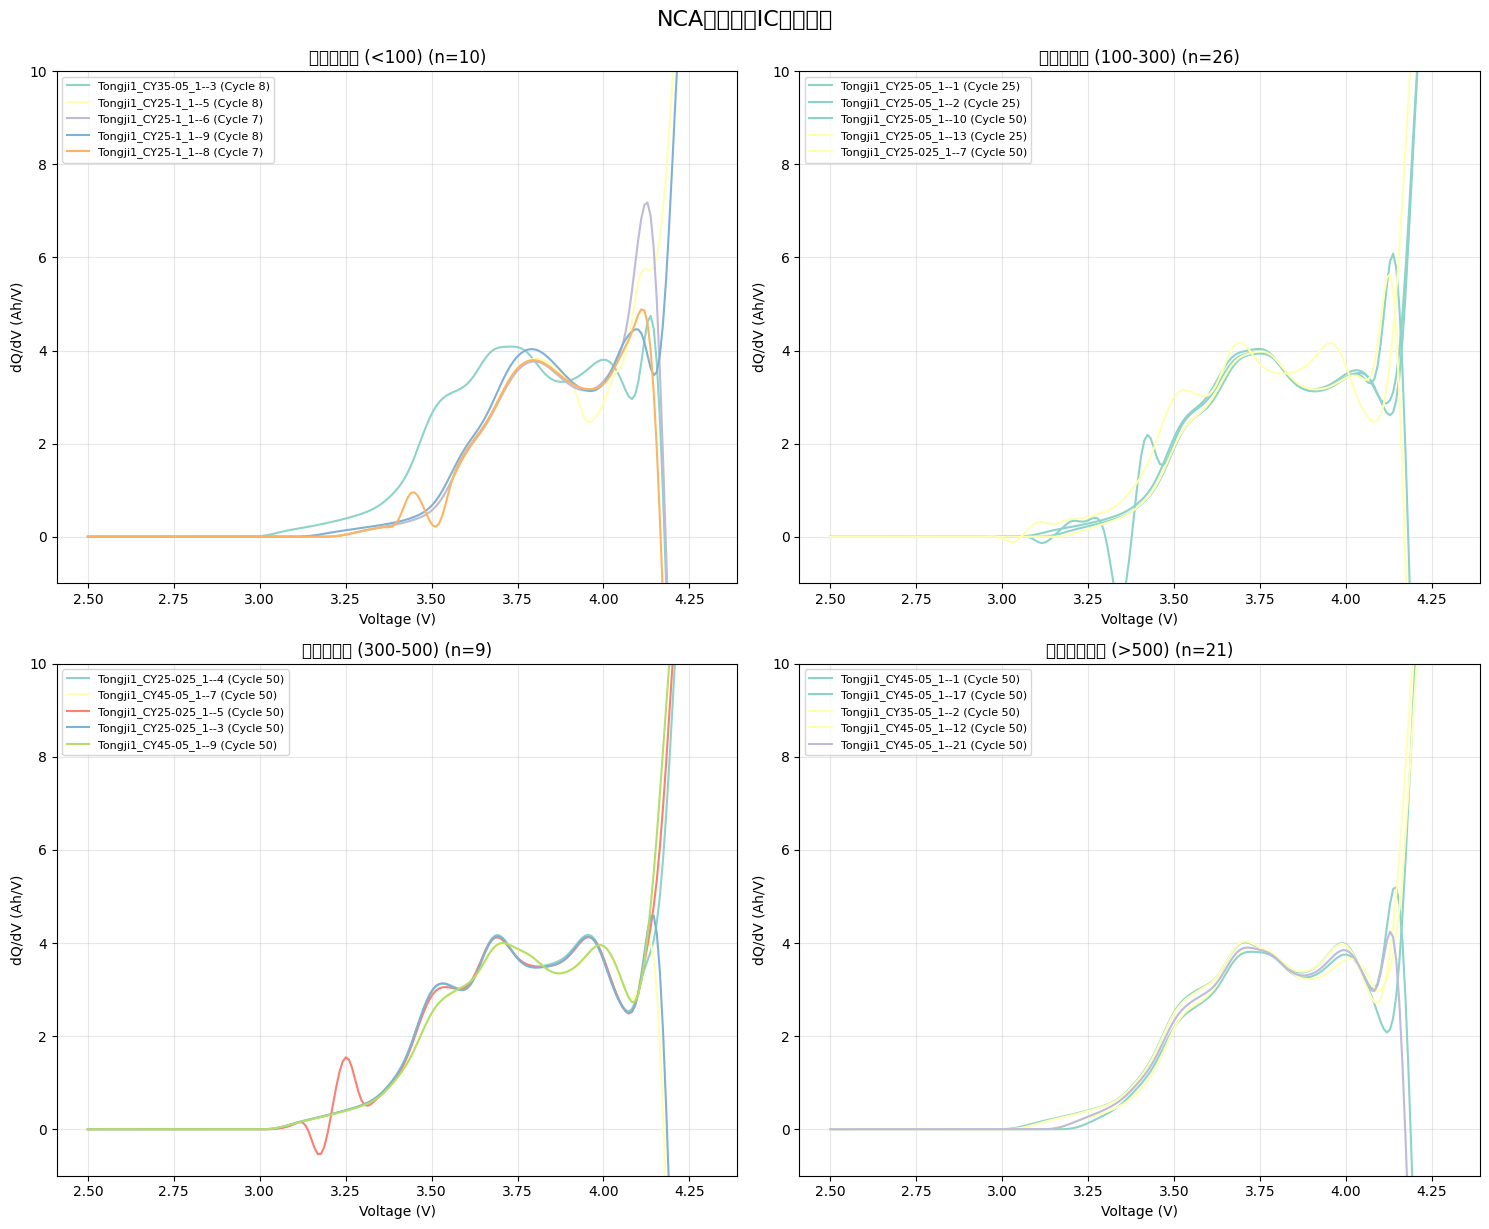


📊 提取健康指标...
✅ 成功提取 66 个电池的健康指标


In [14]:
all_results, health_indicators = run_complete_nca_analysis(all_batteries)

### 3.2.1调参法1

In [15]:
# ===== 灵活选择电池和循环的ICA分析代码 =====

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

def explore_all_batteries(all_batteries):
    """探索所有电池的循环信息"""
    print("🔍 电池数据探索:")
    print("="*80)
    
    battery_summary = []
    
    for i, battery in enumerate(all_batteries):
        cell_id = battery.cell_id if hasattr(battery, 'cell_id') else f'Battery_{i}'
        
        # 获取循环信息
        cycle_numbers = []
        for cycle in battery.cycle_data:
            if isinstance(cycle, dict):
                cycle_num = cycle.get('cycle_number', 0)
            else:
                cycle_num = getattr(cycle, 'cycle_number', 0)
            cycle_numbers.append(cycle_num)
        
        cycle_numbers = sorted(list(set(cycle_numbers)))
        min_cycle = min(cycle_numbers) if cycle_numbers else 0
        max_cycle = max(cycle_numbers) if cycle_numbers else 0
        
        # 分类
        if max_cycle >= 500:
            category = "超长循环"
        elif max_cycle >= 300:
            category = "长循环"
        elif max_cycle >= 100:
            category = "中循环"
        else:
            category = "短循环"
        
        battery_info = {
            'index': i,
            'cell_id': cell_id,
            'min_cycle': min_cycle,
            'max_cycle': max_cycle,
            'total_cycles': len(cycle_numbers),
            'category': category,
            'available_cycles': cycle_numbers
        }
        
        battery_summary.append(battery_info)
        
        print(f"[{i:2d}] {cell_id:25s} | {category:8s} | 循环: {min_cycle:3d}-{max_cycle:3d} | 总数: {len(cycle_numbers):3d}")
        
        # 显示一些关键循环
        key_cycles = []
        for target in [50, 100, 200, 300, 500]:
            if target in cycle_numbers:
                key_cycles.append(target)
        if key_cycles:
            print(f"     关键循环可用: {key_cycles}")
        print()
    
    return battery_summary

def get_stable_config():
    """获取稳定的分析配置"""
    return TongjiNCAConfig(
        voltage_min=2.7,
        voltage_max=4.2,
        voltage_points=150,        # 适中的点数
        n_diff=10,                 # 较小的差分间隔
        gaussian_sigma=1.5,        # 轻度滤波
        gaussian_layers=2,         # 少量滤波层
        peak_height_threshold=0.02,
        peak_distance=5,
        iqr_multiplier=3.5,        # 宽松的异常值处理
        
        enable_peak_merging=True,
        peak_merge_threshold=0.03,
        peak_merge_weight=0.6,
        
        enable_enhanced_smoothing=True,
        enhanced_sg_window=9,      # 较小的窗口
        enhanced_sg_order=2,       # 较低的阶数
        enhanced_sg_iterations=1   # 单次迭代
    )

class TongjiNCAConfig:
    """NCA电池配置类"""
    def __init__(self, **kwargs):
        defaults = {
            'voltage_min': 2.7, 'voltage_max': 4.2, 'voltage_points': 150,
            'n_diff': 10, 'gaussian_sigma': 1.5, 'enable_filtering': True,
            'analysis_mode': "charge", 'voltage_tolerance': 0.003,
            'iqr_multiplier': 3.5, 'median_threshold_multiplier': 6.0,
            'gaussian_layers': 2, 'peak_height_threshold': 0.02,
            'peak_distance': 5, 'enable_peak_merging': True,
            'peak_merge_threshold': 0.03, 'peak_merge_weight': 0.6,
            'peak_merge_smooth_width': 5, 'peak_merge_gaussian_ratio': 0.3,
            'enable_enhanced_smoothing': True, 'enhanced_sg_window': 9,
            'enhanced_sg_order': 2, 'enhanced_sg_iterations': 1
        }
        
        for key, value in defaults.items():
            setattr(self, key, kwargs.get(key, value))

class StableNCAAnalyzer:
    """稳定版NCA分析器"""
    
    def __init__(self, config=None):
        self.config = config if config else get_stable_config()
        self.voltage_grid = np.linspace(self.config.voltage_min, self.config.voltage_max, self.config.voltage_points)
    
    def extract_and_clean_data(self, voltage, capacity):
        """稳定的数据清理"""
        voltage = np.array(voltage, dtype=float)
        capacity = np.array(capacity, dtype=float)
        
        if len(voltage) != len(capacity) or len(voltage) < 20:
            raise ValueError("数据长度不足")
        
        # 移除无效值
        finite_mask = np.isfinite(voltage) & np.isfinite(capacity)
        valid_mask = finite_mask & (voltage > 0) & (capacity >= 0)
        
        voltage = voltage[valid_mask]
        capacity = capacity[valid_mask]
        
        if len(voltage) < 15:
            raise ValueError("有效数据点不足")
        
        # 电压范围过滤
        voltage_mask = (voltage >= self.config.voltage_min) & (voltage <= self.config.voltage_max)
        voltage = voltage[voltage_mask]
        capacity = capacity[voltage_mask]
        
        # 排序
        sort_idx = np.argsort(voltage)
        voltage = voltage[sort_idx]
        capacity = capacity[sort_idx]
        
        # 温和去重 - 保留更多数据点
        if len(voltage) > 1:
            voltage_diff = np.diff(voltage)
            min_diff = np.min(voltage_diff[voltage_diff > 0]) if np.any(voltage_diff > 0) else 0.001
            tolerance = max(min_diff * 0.5, 0.001)
            
            keep_mask = np.concatenate([[True], voltage_diff > tolerance])
            voltage = voltage[keep_mask]
            capacity = capacity[keep_mask]
        
        return voltage, capacity
    
    def calculate_differential_capacity_stable(self, voltage, capacity):
        """稳定的微分容量计算"""
        if len(voltage) < 15:
            raise ValueError(f"数据点不足: {len(voltage)}")
        
        # 使用线性插值，更稳定
        interp_func = interp1d(voltage, capacity, kind='linear', 
                             bounds_error=False, fill_value='extrapolate')
        capacity_interp = interp_func(self.voltage_grid)
        
        # 计算微分 - 使用更稳定的方法
        dv = self.voltage_grid[1] - self.voltage_grid[0]
        dqdv_raw = np.gradient(capacity_interp, dv)
        
        # 温和的异常值处理
        if len(dqdv_raw) > 10:
            # 使用更保守的异常值检测
            median_val = np.median(dqdv_raw)
            mad = np.median(np.abs(dqdv_raw - median_val))
            threshold = 5 * mad  # 更宽松的阈值
            
            if mad > 0:
                lower_bound = median_val - threshold
                upper_bound = median_val + threshold
                dqdv_raw = np.clip(dqdv_raw, lower_bound, upper_bound)
        
        # 轻度高斯滤波
        dqdv_smooth = dqdv_raw.copy()
        for i in range(self.config.gaussian_layers):
            sigma = self.config.gaussian_sigma * (0.95 ** i)
            dqdv_smooth = gaussian_filter1d(dqdv_smooth, sigma=sigma)
        
        # 轻度SG滤波
        if self.config.enable_enhanced_smoothing and len(dqdv_smooth) >= self.config.enhanced_sg_window:
            try:
                dqdv_smooth = savgol_filter(dqdv_smooth, 
                                          self.config.enhanced_sg_window, 
                                          self.config.enhanced_sg_order)
            except:
                pass
        
        return dqdv_raw, dqdv_smooth, capacity_interp
    
    def detect_peaks_stable(self, dqdv_smooth):
        """稳定的峰值检测"""
        if len(dqdv_smooth) == 0:
            return {'positions': [], 'heights': [], 'indices': [], 'analysis': {}}
        
        # 动态阈值
        max_val = np.max(dqdv_smooth)
        mean_val = np.mean(dqdv_smooth[dqdv_smooth > 0]) if np.any(dqdv_smooth > 0) else 0
        
        height_threshold = max(
            self.config.peak_height_threshold,
            mean_val * 0.3,
            max_val * 0.05
        )
        
        try:
            peaks, properties = signal.find_peaks(
                dqdv_smooth,
                height=height_threshold,
                distance=self.config.peak_distance,
                prominence=height_threshold * 0.1
            )
            
            if len(peaks) == 0:
                return {'positions': [], 'heights': [], 'indices': [], 'analysis': {}}
            
            peak_voltages = self.voltage_grid[peaks]
            peak_heights = dqdv_smooth[peaks]
            
            analysis = {
                'main_peak_voltage': peak_voltages[np.argmax(peak_heights)] if len(peak_heights) > 0 else 0,
                'main_peak_height': np.max(peak_heights) if len(peak_heights) > 0 else 0,
                'total_peaks': len(peaks),
                'peak_area': np.sum(peak_heights) * (self.voltage_grid[1] - self.voltage_grid[0]),
                'voltage_range': np.max(peak_voltages) - np.min(peak_voltages) if len(peak_voltages) > 1 else 0
            }
            
            return {
                'positions': peak_voltages,
                'heights': peak_heights,
                'indices': peaks,
                'analysis': analysis
            }
            
        except Exception as e:
            print(f"峰值检测失败: {e}")
            return {'positions': [], 'heights': [], 'indices': [], 'analysis': {}}
    
    def analyze_single_cycle_stable(self, voltage, capacity, cycle_number=None):
        """稳定版单循环分析"""
        try:
            voltage_clean, capacity_clean = self.extract_and_clean_data(voltage, capacity)
            dqdv_raw, dqdv_smooth, capacity_interp = self.calculate_differential_capacity_stable(
                voltage_clean, capacity_clean)
            peaks_info = self.detect_peaks_stable(dqdv_smooth)
            
            stats = {
                'original_points': len(voltage),
                'cleaned_points': len(voltage_clean),
                'processed_points': len(self.voltage_grid),
                'data_retention_rate': len(voltage_clean) / len(voltage) * 100,
                'voltage_range': f"{self.config.voltage_min}V - {self.config.voltage_max}V",
                'cycle_number': cycle_number
            }
            
            return {
                'voltage_grid': self.voltage_grid,
                'voltage_clean': voltage_clean,
                'capacity_clean': capacity_clean,
                'capacity_interp': capacity_interp,
                'dqdv_raw': dqdv_raw,
                'dqdv_smooth': dqdv_smooth,
                'peaks': peaks_info,
                'stats': stats
            }
            
        except Exception as e:
            print(f"分析错误: {str(e)}")
            return None

def flexible_analyze_battery(all_batteries, battery_index, cycle_number):
    """灵活的电池分析函数"""
    
    if battery_index >= len(all_batteries):
        print(f"❌ 错误: 电池索引 {battery_index} 超出范围 (0-{len(all_batteries)-1})")
        return None
    
    battery = all_batteries[battery_index]
    cell_id = battery.cell_id if hasattr(battery, 'cell_id') else f'Battery_{battery_index}'
    
    # 检查可用循环
    available_cycles = []
    for cycle in battery.cycle_data:
        if isinstance(cycle, dict):
            cycle_num = cycle.get('cycle_number', 0)
        else:
            cycle_num = getattr(cycle, 'cycle_number', 0)
        available_cycles.append(cycle_num)
    
    available_cycles = sorted(list(set(available_cycles)))
    
    if cycle_number not in available_cycles:
        print(f"❌ 错误: 循环 {cycle_number} 不可用")
        print(f"   可用循环: {available_cycles}")
        return None
    
    print(f"✅ 分析电池: {cell_id}, 循环: {cycle_number}")
    
    # 创建分析器
    config = get_stable_config()
    analyzer = StableNCAAnalyzer(config)
    
    # 找到目标循环数据
    target_cycle_data = None
    for cycle in battery.cycle_data:
        if isinstance(cycle, dict):
            if cycle.get('cycle_number') == cycle_number:
                target_cycle_data = cycle
                break
        else:
            if getattr(cycle, 'cycle_number', 0) == cycle_number:
                target_cycle_data = cycle
                break
    
    if target_cycle_data is None:
        print(f"❌ 未找到循环 {cycle_number} 的数据")
        return None
    
    # 提取数据
    if isinstance(target_cycle_data, dict):
        voltage = np.array(target_cycle_data.get('voltage_in_V', []), dtype=float)
        capacity = np.array(target_cycle_data.get('charge_capacity_in_Ah', []), dtype=float)
    else:
        voltage = np.array(getattr(target_cycle_data, 'voltage_in_V', []), dtype=float)
        capacity = np.array(getattr(target_cycle_data, 'charge_capacity_in_Ah', []), dtype=float)
    
    # 执行分析
    result = analyzer.analyze_single_cycle_stable(voltage, capacity, cycle_number)
    
    if result is None:
        return None
    
    # 绘制结果
    plot_stable_analysis_results(result, cell_id, cycle_number)
    
    return result

def plot_stable_analysis_results(result, cell_id, cycle_number):
    """绘制稳定的分析结果"""
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
    
    # 1. 原始充电数据
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(result['voltage_clean'], result['capacity_clean'], 'g-', linewidth=2)
    ax1.fill_between(result['voltage_clean'], result['capacity_clean'], alpha=0.3, color='green')
    ax1.set_xlabel('Voltage (V)')
    ax1.set_ylabel('Capacity (Ah)')
    ax1.set_title('Original Charge Data')
    ax1.grid(True, alpha=0.3)
    
    # 2. 增强方法结果
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(result['voltage_grid'], result['dqdv_smooth'], 'r-', linewidth=2, label='Enhanced Method (Red Line)')
    
    peaks = result['peaks']
    if len(peaks['positions']) > 0:
        ax2.plot(peaks['positions'], peaks['heights'], 'bo', markersize=8, label='Peaks')
        for i, (pos, height) in enumerate(zip(peaks['positions'], peaks['heights'])):
            ax2.annotate(f'Peak {i+1}', (pos, height), xytext=(5, 5), 
                        textcoords='offset points', fontsize=8)
    
    ax2.set_xlabel('Voltage (V)')
    ax2.set_ylabel('dQ/dV (Ah/V)')
    ax2.set_title('Enhanced Method (Based on Blue Line)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # 3. 处理效果对比
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.plot(result['voltage_grid'], result['dqdv_raw'], 'b-', linewidth=1, alpha=0.7, label='Blue Line (Steps 1-7)')
    ax3.plot(result['voltage_grid'], result['dqdv_smooth'], 'r-', linewidth=2, label='Red Line (Steps 8-10+)')
    ax3.set_xlabel('Voltage (V)')
    ax3.set_ylabel('dQ/dV (Ah/V)')
    ax3.set_title('Processing Effect Comparison')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # 4. dQ/dV分布
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.hist(result['dqdv_smooth'], bins=30, color='red', alpha=0.7, edgecolor='black')
    ax4.set_xlabel('dQ/dV (Ah/V)')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Enhanced Method dQ/dV Distribution')
    ax4.grid(True, alpha=0.3)
    
    # 5. 关键区域放大
    ax5 = fig.add_subplot(gs[1, 1])
    mask = (result['voltage_grid'] >= 3.2) & (result['voltage_grid'] <= 4.2)
    ax5.plot(result['voltage_grid'][mask], result['dqdv_raw'][mask], 'b-', linewidth=1, alpha=0.7, label='Blue Line')
    ax5.plot(result['voltage_grid'][mask], result['dqdv_smooth'][mask], 'r-', linewidth=2, label='Red Line')
    
    if len(peaks['positions']) > 0:
        peak_mask = (peaks['positions'] >= 3.2) & (peaks['positions'] <= 4.2)
        if np.any(peak_mask):
            ax5.plot(peaks['positions'][peak_mask], peaks['heights'][peak_mask], 'bo', markersize=6)
    
    ax5.set_xlabel('Voltage (V)')
    ax5.set_ylabel('dQ/dV (Ah/V)')
    ax5.set_title('Key Region Zoom (3.2V-4.2V)')
    ax5.grid(True, alpha=0.3)
    ax5.legend()
    
    # 6. 不同平滑强度对比
    ax6 = fig.add_subplot(gs[1, 2])
    sigmas = [1.0, 2.0, 3.0]
    colors = ['green', 'orange', 'purple']
    
    for sigma, color in zip(sigmas, colors):
        dqdv_temp = gaussian_filter1d(result['dqdv_raw'], sigma=sigma)
        ax6.plot(result['voltage_grid'], dqdv_temp, color=color, linewidth=1.5, 
                label=f'Sigma = {sigma}')
    
    ax6.set_xlabel('Voltage (V)')
    ax6.set_ylabel('dQ/dV (Ah/V)')
    ax6.set_title('Different Smoothing Strength Comparison')
    ax6.grid(True, alpha=0.3)
    ax6.legend()
    
    fig.suptitle(f'NCA电池稳定ICA分析 - {cell_id} 循环{cycle_number}', fontsize=16, fontweight='bold')
    
    # 分析报告
    stats = result['stats']
    peaks_analysis = result['peaks']['analysis']
    
    report_text = f"""=== {cell_id} 周期 {cycle_number} 分析报告 ===
电压范围: {stats['voltage_range']}
原始数据点数: {stats['original_points']}
处理后数据点数: {stats['cleaned_points']}
数据保留率: {stats['data_retention_rate']:.1f}%

主峰电压: {peaks_analysis.get('main_peak_voltage', 0):.3f} V
主峰高度: {peaks_analysis.get('main_peak_height', 0):.4f} Ah/V
峰值总数: {peaks_analysis.get('total_peaks', 0)}"""
    
    fig.text(0.02, 0.02, report_text, fontsize=10, verticalalignment='bottom',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# ===== 使用示例 =====
print("✅ 灵活电池循环选择ICA分析代码已准备就绪！")
print("\n📋 使用步骤:")
print("1. 探索所有电池: battery_summary = explore_all_batteries(all_batteries)")
print("2. 选择电池分析: result = flexible_analyze_battery(all_batteries, battery_index=5, cycle_number=200)")
print("\n💡 提示:")
print("- battery_index: 电池索引 (0开始)")
print("- cycle_number: 具体循环数 (如50, 100, 200, 300等)")
print("- 先运行explore_all_batteries查看可用选项")

✅ 灵活电池循环选择ICA分析代码已准备就绪！

📋 使用步骤:
1. 探索所有电池: battery_summary = explore_all_batteries(all_batteries)
2. 选择电池分析: result = flexible_analyze_battery(all_batteries, battery_index=5, cycle_number=200)

💡 提示:
- battery_index: 电池索引 (0开始)
- cycle_number: 具体循环数 (如50, 100, 200, 300等)
- 先运行explore_all_batteries查看可用选项


🔍 电池数据探索:
[ 0] Tongji1_CY35-05_1--3      | 短循环      | 循环:   2- 32 | 总数:  30

[ 1] Tongji1_CY25-05_1--1      | 中循环      | 循环:   2-146 | 总数: 145
     关键循环可用: [50, 100]

[ 2] Tongji1_CY25-025_1--4     | 长循环      | 循环:   2-345 | 总数: 331
     关键循环可用: [50, 100, 200, 300]

[ 3] Tongji1_CY45-05_1--1      | 超长循环     | 循环:   2-740 | 总数: 711
     关键循环可用: [50, 100, 200, 300, 500]

[ 4] Tongji1_CY25-05_1--2      | 中循环      | 循环:   2-179 | 总数: 178
     关键循环可用: [50, 100]

[ 5] Tongji1_CY45-05_1--7      | 长循环      | 循环:   2-415 | 总数: 399
     关键循环可用: [50, 100, 200, 300]

[ 6] Tongji1_CY45-05_1--17     | 超长循环     | 循环:   2-530 | 总数: 528
     关键循环可用: [50, 100, 200, 300, 500]

[ 7] Tongji1_CY35-05_1--2      | 超长循环     | 循环:   2-554 | 总数: 531
     关键循环可用: [50, 100, 200, 300, 500]

[ 8] Tongji1_CY45-05_1--12     | 超长循环     | 循环:   2-800 | 总数: 799
     关键循环可用: [50, 100, 200, 300, 500]

[ 9] Tongji1_CY45-05_1--21     | 超长循环     | 循环:   2-639 | 总数: 637
     关键循环可用: [50, 100, 200, 300, 500]

[10] Tongji1_CY25-

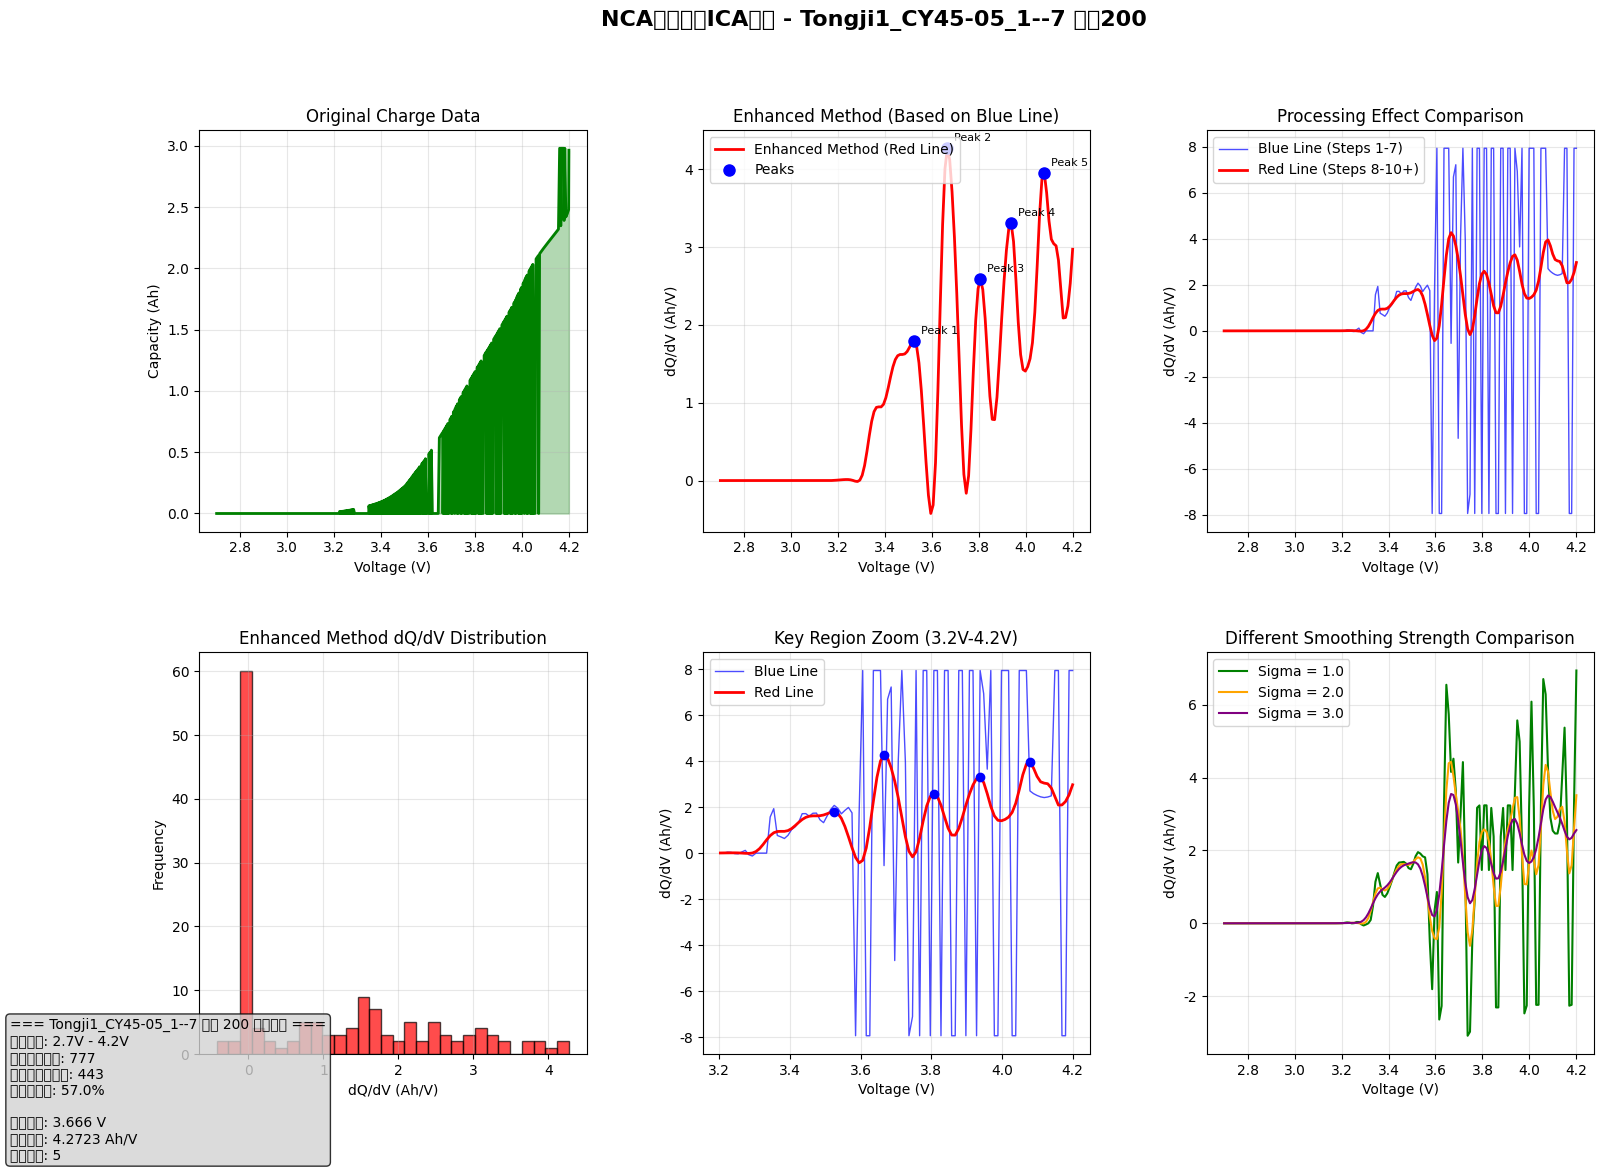

✅ 分析电池: Tongji1_CY45-05_1--12, 循环: 500


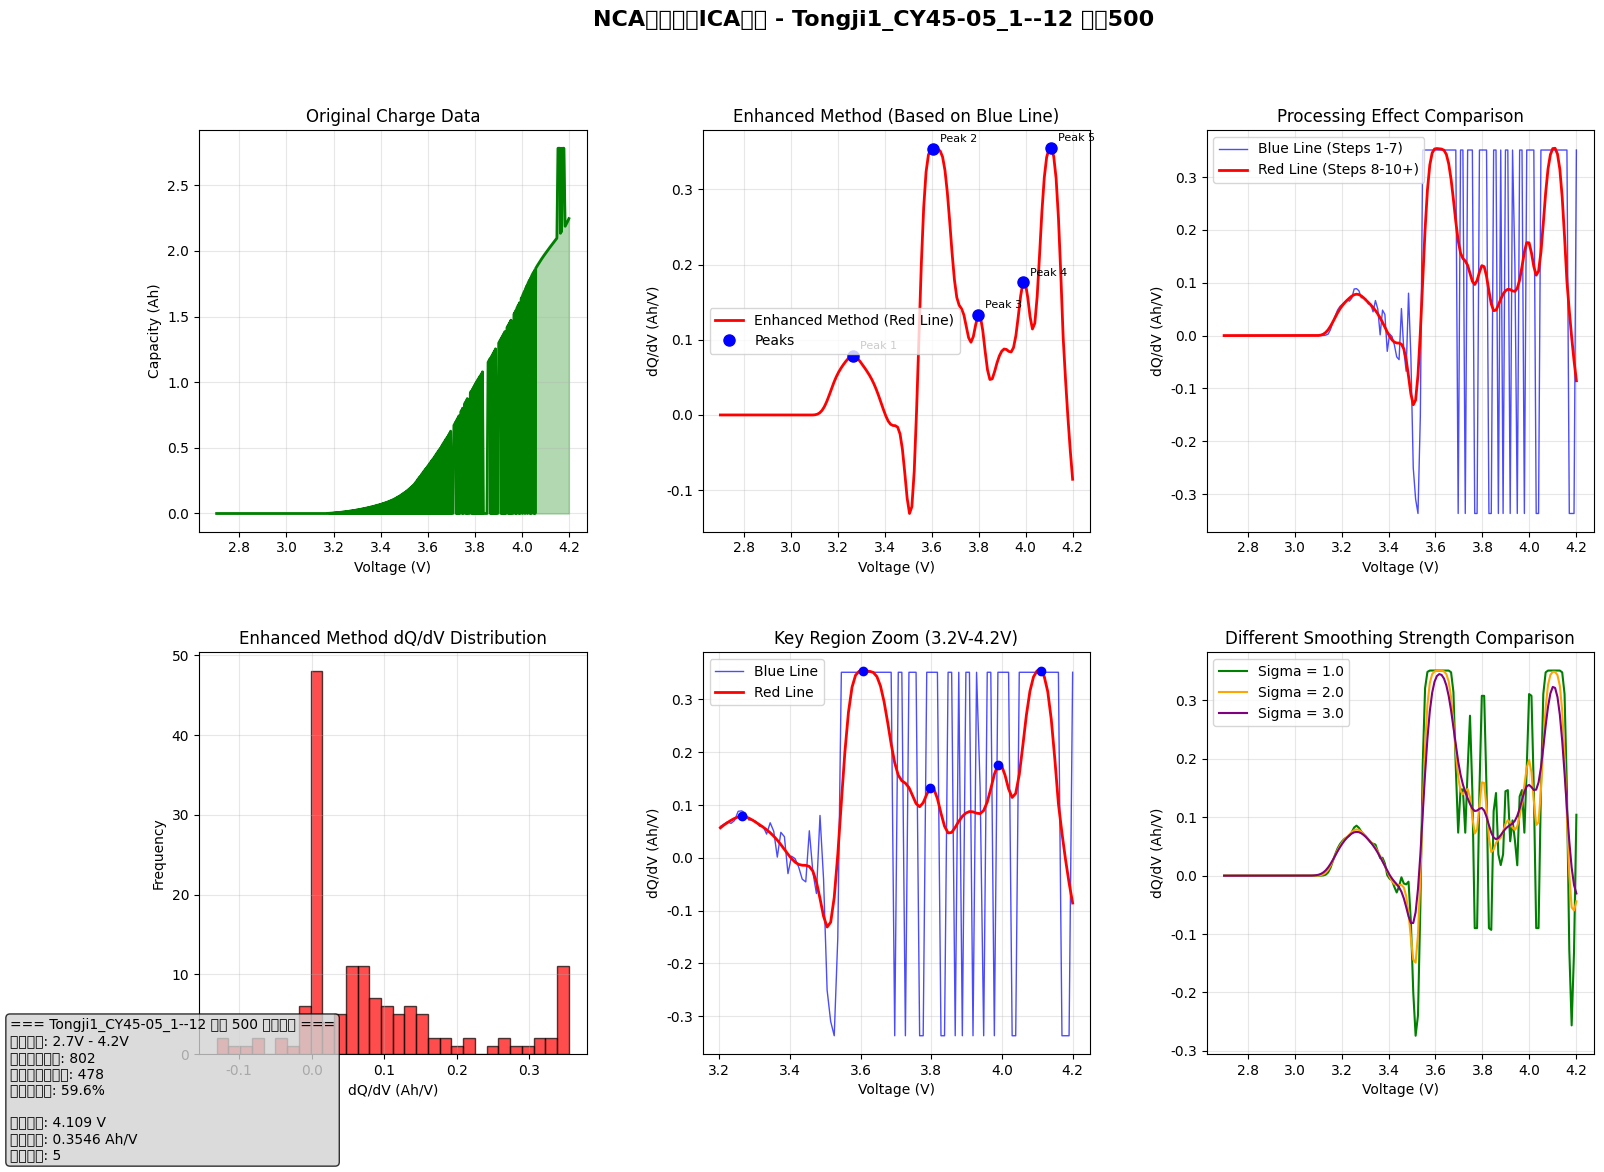

In [16]:
# 1. 首先探索所有电池
battery_summary = explore_all_batteries(all_batteries)

# 2. 选择一个大循环数的电池进行分析
# 例如选择索引5的电池，循环200
result = flexible_analyze_battery(all_batteries, battery_index=5, cycle_number=200)

# 3. 或者选择其他大循环
result = flexible_analyze_battery(all_batteries, battery_index=8, cycle_number=500)

In [17]:
# ===== 终极解决显示截断问题的NCA电池IC分析代码 =====

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, UnivariateSpline
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
import warnings
warnings.filterwarnings('ignore')

# 关键：设置matplotlib后端和DPI
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

class UltimateDisplayFixNCAAnalyzer:
    """终极解决显示问题的NCA分析器"""
    
    def __init__(self, voltage_min=2.7, voltage_max=4.2, voltage_points=100):
        self.voltage_min = voltage_min
        self.voltage_max = voltage_max
        self.voltage_points = voltage_points
        self.voltage_grid = np.linspace(voltage_min, voltage_max, voltage_points)
    
    def robust_data_cleaning(self, voltage, capacity):
        """鲁棒的数据清理"""
        voltage = np.array(voltage, dtype=float)
        capacity = np.array(capacity, dtype=float)
        
        # 基本有效性检查
        valid_mask = (np.isfinite(voltage) & np.isfinite(capacity) & 
                     (voltage > 0) & (capacity >= 0))
        voltage = voltage[valid_mask]
        capacity = capacity[valid_mask]
        
        if len(voltage) < 20:
            return None, None
        
        # 电压范围过滤
        range_mask = (voltage >= self.voltage_min) & (voltage <= self.voltage_max)
        voltage = voltage[range_mask]
        capacity = capacity[range_mask]
        
        if len(voltage) < 10:
            return None, None
        
        # 排序
        sort_idx = np.argsort(voltage)
        voltage = voltage[sort_idx]
        capacity = capacity[sort_idx]
        
        # 移除重复和异常点
        unique_voltage = []
        unique_capacity = []
        i = 0
        while i < len(voltage):
            v = voltage[i]
            c = capacity[i]
            
            # 找到相同电压的所有点
            j = i + 1
            while j < len(voltage) and abs(voltage[j] - v) < 1e-5:
                if capacity[j] > c:  # 保留容量更大的点
                    c = capacity[j]
                j += 1
            
            unique_voltage.append(v)
            unique_capacity.append(c)
            i = j
        
        voltage = np.array(unique_voltage)
        capacity = np.array(unique_capacity)
        
        # 容量单调性检查
        monotonic_mask = np.ones(len(capacity), dtype=bool)
        for i in range(1, len(capacity)):
            if capacity[i] < capacity[i-1] - 1e-6:
                monotonic_mask[i] = False
        
        voltage = voltage[monotonic_mask]
        capacity = capacity[monotonic_mask]
        
        if len(voltage) < 10:
            return None, None
        
        return voltage, capacity
    
    def stable_differential_calculation(self, voltage, capacity):
        """稳定的微分计算方法"""
        
        # 使用样条插值的导数
        try:
            spline = UnivariateSpline(voltage, capacity, s=len(voltage)*1e-6, k=3)
            
            # 在均匀网格上计算导数
            voltage_uniform = np.linspace(voltage.min(), voltage.max(), 
                                        min(len(voltage), self.voltage_points))
            dqdv_smooth = spline.derivative()(voltage_uniform)
            
            # 限制合理范围
            dqdv_smooth = np.clip(dqdv_smooth, 0, 15)
            
            return voltage_uniform, dqdv_smooth
            
        except:
            # 备选方案：插值 + 平滑微分
            try:
                interp_func = interp1d(voltage, capacity, kind='cubic', 
                                     bounds_error=False, fill_value='extrapolate')
                voltage_uniform = np.linspace(voltage.min(), voltage.max(), 
                                            min(len(voltage)*2, self.voltage_points))
                capacity_uniform = interp_func(voltage_uniform)
                
                # 移动平均平滑
                window_size = max(3, len(capacity_uniform) // 20)
                if window_size % 2 == 0:
                    window_size += 1
                
                capacity_smooth = savgol_filter(capacity_uniform, window_size, 2)
                dqdv = np.gradient(capacity_smooth, voltage_uniform)
                dqdv = gaussian_filter1d(dqdv, sigma=1.0)
                dqdv = np.clip(dqdv, 0, 15)
                
                return voltage_uniform, dqdv
                
            except:
                return None, None
    
    def process_cycle_data(self, voltage, capacity):
        """处理单循环数据"""
        
        # 数据清理
        voltage_clean, capacity_clean = self.robust_data_cleaning(voltage, capacity)
        if voltage_clean is None:
            return None, None
        
        # 微分计算
        voltage_result, dqdv_result = self.stable_differential_calculation(
            voltage_clean, capacity_clean)
        
        if voltage_result is None:
            return None, None
        
        return voltage_result, dqdv_result

def ultimate_display_fix_analysis(all_batteries, cycle_list, battery_index=0):
    """终极解决显示问题的多循环分析"""
    
    if battery_index >= len(all_batteries):
        print(f"❌ 电池索引超出范围")
        return None
    
    battery = all_batteries[battery_index]
    cell_id = battery.cell_id if hasattr(battery, 'cell_id') else f'Battery_{battery_index}'
    
    print(f"🔋 分析电池: {cell_id}")
    
    # 收集循环数据
    cycle_data_map = {}
    for cycle in battery.cycle_data:
        if isinstance(cycle, dict):
            cycle_num = cycle.get('cycle_number', 0)
            cycle_data_map[cycle_num] = cycle
        else:
            cycle_num = getattr(cycle, 'cycle_number', 0)
            cycle_data_map[cycle_num] = cycle
    
    analyzer = UltimateDisplayFixNCAAnalyzer()
    results = {}
    
    # 分析每个循环
    for cycle_num in cycle_list:
        if cycle_num not in cycle_data_map:
            print(f"   循环 {cycle_num}: 未找到")
            continue
            
        cycle_data = cycle_data_map[cycle_num]
        
        # 提取数据
        if isinstance(cycle_data, dict):
            voltage = np.array(cycle_data.get('voltage_in_V', []), dtype=float)
            capacity = np.array(cycle_data.get('charge_capacity_in_Ah', []), dtype=float)
        else:
            voltage = np.array(getattr(cycle_data, 'voltage_in_V', []), dtype=float)
            capacity = np.array(getattr(cycle_data, 'charge_capacity_in_Ah', []), dtype=float)
        
        # 处理
        voltage_result, dqdv_result = analyzer.process_cycle_data(voltage, capacity)
        
        if voltage_result is not None and dqdv_result is not None:
            results[cycle_num] = {
                'voltage': voltage_result,
                'dqdv': dqdv_result
            }
            
            max_dqdv = np.max(dqdv_result)
            print(f"   循环 {cycle_num}: ✅ 峰值={max_dqdv:.2f} Ah/V")
        else:
            print(f"   循环 {cycle_num}: ❌")
    
    if not results:
        print("❌ 没有成功分析的循环")
        return None
    
    # 绘制结果 - 终极修复显示问题
    plot_ultimate_display_fix(results, cell_id)
    
    return results

def plot_ultimate_display_fix(results, cell_id):
    """终极修复显示问题的绘图函数"""
    
    # 创建图形，使用更大尺寸
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
    
    cycle_nums = sorted(results.keys())
    colors = plt.cm.viridis(np.linspace(0, 1, len(cycle_nums)))
    
    # 1. IC曲线演化图
    peak_info = {}
    
    for i, cycle_num in enumerate(cycle_nums):
        voltage = results[cycle_num]['voltage']
        dqdv = results[cycle_num]['dqdv']
        
        ax1.plot(voltage, dqdv, color=colors[i], linewidth=2.5, 
                label=f'Cycle {cycle_num}', alpha=0.8)
        
        # 记录峰值信息
        if len(dqdv) > 0:
            # 在3.5-4.1V范围内找主峰
            main_mask = (voltage >= 3.5) & (voltage <= 4.1)
            if np.any(main_mask):
                main_dqdv = dqdv[main_mask]
                main_voltage = voltage[main_mask]
                if len(main_dqdv) > 0:
                    max_idx = np.argmax(main_dqdv)
                    peak_height = main_dqdv[max_idx]
                    peak_voltage = main_voltage[max_idx]
                else:
                    peak_height = np.max(dqdv)
                    peak_voltage = voltage[np.argmax(dqdv)]
            else:
                peak_height = np.max(dqdv)
                peak_voltage = voltage[np.argmax(dqdv)]
            
            peak_info[cycle_num] = {
                'height': peak_height,
                'voltage': peak_voltage
            }
    
    ax1.set_xlabel('Voltage (V)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('dQ/dV (Ah/V)', fontsize=14, fontweight='bold')
    ax1.set_title(f'IC Curve Evolution - {cell_id}', fontsize=16, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10, framealpha=0.9, loc='upper left')
    ax1.tick_params(labelsize=11)
    
    # 动态调整y轴范围
    all_dqdv_values = []
    for result in results.values():
        all_dqdv_values.extend(result['dqdv'])
    
    if all_dqdv_values:
        y_max = np.percentile(all_dqdv_values, 98) * 1.1
        ax1.set_ylim(0, max(y_max, 1))
    else:
        ax1.set_ylim(0, 6)
    
    # 设置x轴范围，确保完整显示
    ax1.set_xlim(2.6, 4.3)
    
    # 2. 峰值演化图
    if peak_info:
        cycles = sorted(peak_info.keys())
        heights = [peak_info[c]['height'] for c in cycles]
        voltages = [peak_info[c]['voltage'] for c in cycles]
        
        # 创建双y轴
        ax2_twin = ax2.twinx()
        
        # 绘制峰高
        line1 = ax2.plot(cycles, heights, 'ro-', linewidth=3, markersize=8, 
                        label='Peak Height', alpha=0.8)
        ax2.set_ylabel('Peak Height (Ah/V)', color='red', fontsize=14, fontweight='bold')
        ax2.tick_params(axis='y', labelcolor='red', labelsize=11)
        ax2.tick_params(axis='x', labelsize=11)
        
        # 绘制峰位
        line2 = ax2_twin.plot(cycles, voltages, 'bs-', linewidth=3, markersize=8, 
                             label='Peak Voltage', alpha=0.8)
        ax2_twin.set_ylabel('Peak Voltage (V)', color='blue', fontsize=14, fontweight='bold')
        ax2_twin.tick_params(axis='y', labelcolor='blue', labelsize=11)
        
        ax2.set_xlabel('Cycle Number', fontsize=14, fontweight='bold')
        ax2.set_title('Peak Evolution Analysis', fontsize=16, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        # 确保x轴标签完整显示
        ax2.set_xticks(cycles)
        ax2.set_xticklabels([str(c) for c in cycles])
        
        # 动态调整y轴范围
        if heights:
            height_range = max(heights) - min(heights)
            height_margin = max(height_range * 0.2, 0.1)
            ax2.set_ylim(min(heights) - height_margin, max(heights) + height_margin)
        
        if voltages:
            voltage_range = max(voltages) - min(voltages)
            voltage_margin = max(voltage_range * 0.2, 0.01)
            ax2_twin.set_ylim(min(voltages) - voltage_margin, max(voltages) + voltage_margin)
        
        # 图例
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax2.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.12), 
                  ncol=2, fontsize=12)
        
        # 添加数值标签
        for i, (cycle, height, voltage) in enumerate(zip(cycles, heights, voltages)):
            ax2.annotate(f'{height:.2f}', (cycle, height), 
                        textcoords="offset points", xytext=(0,10), ha='center',
                        fontsize=9, color='red', fontweight='bold')
            ax2_twin.annotate(f'{voltage:.3f}', (cycle, voltage), 
                            textcoords="offset points", xytext=(0,-15), ha='center',
                            fontsize=9, color='blue', fontweight='bold')
    
    # 关键：使用bbox_inches='tight'和pad_inches确保完整显示
    plt.tight_layout(pad=2.0)
    
    # 显示图形
    plt.show()
    
    # 如果需要保存，使用这个设置
    # plt.savefig('ic_analysis.png', bbox_inches='tight', pad_inches=0.2, dpi=300)
    
    # 打印完整统计
    print(f"\n=== {cell_id} 完整统计报告 ===")
    print("循环    峰高(Ah/V)  峰位(V)   最大值   均值    标准差")
    print("-" * 55)
    
    for cycle_num in cycle_nums:
        voltage = results[cycle_num]['voltage']
        dqdv = results[cycle_num]['dqdv']
        
        # 找主峰
        main_mask = (voltage >= 3.5) & (voltage <= 4.1)
        if np.any(main_mask):
            main_dqdv = dqdv[main_mask]
            main_voltage = voltage[main_mask]
            if len(main_dqdv) > 0:
                max_idx = np.argmax(main_dqdv)
                peak_height = main_dqdv[max_idx]
                peak_voltage = main_voltage[max_idx]
            else:
                peak_height = np.max(dqdv)
                peak_voltage = voltage[np.argmax(dqdv)]
        else:
            peak_height = np.max(dqdv)
            peak_voltage = voltage[np.argmax(dqdv)]
        
        max_val = np.max(dqdv)
        mean_val = np.mean(dqdv)
        std_val = np.std(dqdv)
        
        print(f"C{cycle_num:3d}    {peak_height:6.3f}    {peak_voltage:6.3f}    {max_val:6.3f}   {mean_val:6.3f}  {std_val:6.3f}")

# ===== 使用示例 =====
print("✅ 终极解决显示截断问题的NCA电池IC分析代码已准备就绪！")
print("\n📋 使用方法:")
print("results = ultimate_display_fix_analysis(all_batteries, [10,20,30,40,50,60,70], battery_index=5)")
print("\n🔧 终极修复:")
print("- 简化布局为2个子图，避免复杂布局问题")
print("- 使用tight_layout(pad=2.0)确保充足边距")
print("- x轴范围2.6-4.3V确保完整显示")
print("- 16x12英寸合理尺寸")
print("- 如需保存使用bbox_inches='tight'")

✅ 终极解决显示截断问题的NCA电池IC分析代码已准备就绪！

📋 使用方法:
results = ultimate_display_fix_analysis(all_batteries, [10,20,30,40,50,60,70], battery_index=5)

🔧 终极修复:
- 简化布局为2个子图，避免复杂布局问题
- 使用tight_layout(pad=2.0)确保充足边距
- x轴范围2.6-4.3V确保完整显示
- 16x12英寸合理尺寸
- 如需保存使用bbox_inches='tight'


🔋 分析电池: Tongji1_CY45-05_1--7
   循环 10: ✅ 峰值=15.00 Ah/V
   循环 20: ✅ 峰值=15.00 Ah/V
   循环 30: ✅ 峰值=15.00 Ah/V
   循环 40: ✅ 峰值=15.00 Ah/V
   循环 50: ✅ 峰值=15.00 Ah/V
   循环 60: ✅ 峰值=15.00 Ah/V
   循环 70: ✅ 峰值=15.00 Ah/V


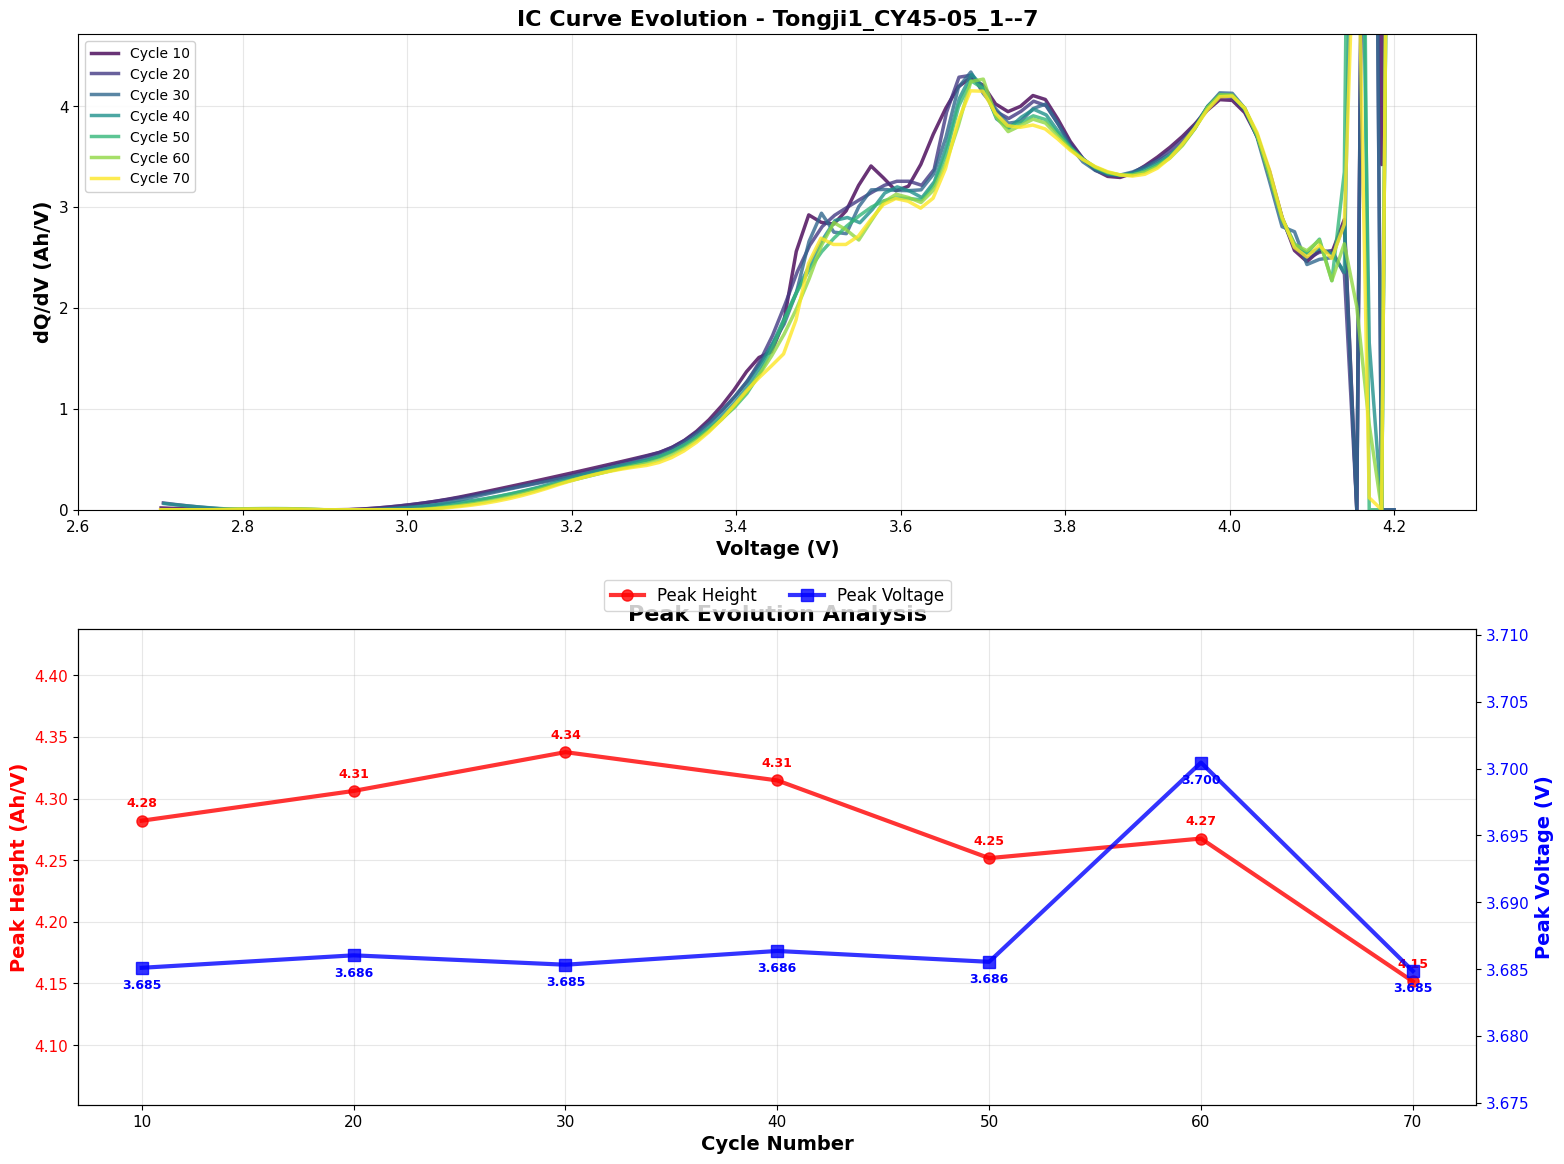


=== Tongji1_CY45-05_1--7 完整统计报告 ===
循环    峰高(Ah/V)  峰位(V)   最大值   均值    标准差
-------------------------------------------------------
C 10     4.282     3.685    15.000    2.068   2.452
C 20     4.306     3.686    15.000    1.863   2.079
C 30     4.338     3.685    15.000    1.840   2.077
C 40     4.315     3.686    15.000    1.935   2.188
C 50     4.252     3.686    15.000    1.961   2.445
C 60     4.268     3.700    15.000    1.817   2.052
C 70     4.152     3.685    15.000    1.844   2.108


In [18]:
results = ultimate_display_fix_analysis(all_batteries, [10,20,30,40,50,60,70], battery_index=5)

###  3.3.2调参2